# Solutions of exercises for Chapter 3

In [88]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings

from sklearn.decomposition import PCA

In [89]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")
register_matplotlib_converters()
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Exercise 1

- The files d_15stocks.csv and m_15stocks.csv contain daily and monthly stock returns data for 15 stocks from January 11, 2000 to March 31, 2013.
- The files d_indexes.csv and m_indexes.csv contain daily and monthly returns data for the volume-weighted and equal-weighted S&P 500market indices (VWRETD and EWRETD, respectively) from January 11, 2000 to March 31,2013.

Using daily and monthly returns data for 15 individual stocks from d_15stocks.csv and m_15stocks.csv, and the equal-weighted and volume-weighted CRSP market indexes (EWRETD and VWRETD, respectively) from d_indexes.csv and m_indexes.csv, perform the following statistical analyses. For the subsample analyses, split the available observations into equal-sized subsamples or at regime changes visually noticeable from the time series plots.
1. Compute the sample mean $\hat{\mu}$, standard deviation $\hat{\sigma}$, and first-order autocorrelation coefficient $\hat{\rho(1)}$ for daily simple returns over the entire sample period for the 15 stocks and two indexes. Split the sample into 4 equal subperiods and compute the same statistics in each subperiod—are they stable over time?
2. Plot histograms of daily simple returns for VWRETD and EWRETD over the entire sample period. Plot another histogram of the normal distribution with mean and variance equal to the sample mean and variance of the returns plotted in the first histograms. Do daily simple returns look approximately normal? Which looks closer to normal: VWRETD or EWRETD?
3. Using daily simple returns for the sample period, construct 99% confidence intervals for $\hat{\mu}$ for VWRETD and EWRETD, and the 15 individual stock return series. Divide the sample into 4 equal subperiods and construct 99% confidence intervals in each of the four subperiods for the 17 series—do they shift a great deal?
4. Compute the skewness, kurtosis, and studentized range of daily simple returns of VWRETD, EWRETD, and the 15 individual stocks over the entire sample period, and in each of the 4 equal subperiods. Which of the skewness, kurtosis, and studentized range estimates are statistically different from the skewness, kurtosis, and studentized range of a normal random variable at the 5% level? For these 17 series, perform the same calculations using monthly data. What do you conclude about the normality of these return series, and why?

#### Data Exploration and Inspection

In [5]:
d_15stock = pd.read_csv('../datasets/d_15stocks.csv',index_col=['TICKER','date'],parse_dates=['date'])
m_15stock = pd.read_csv('../datasets/m_15stocks.csv',index_col=['TICKER','date'],parse_dates=['date'])
d_indexes = pd.read_csv('../datasets/d_indexes.csv',index_col='caldt',parse_dates=['caldt'])
d_indexes.index.name='date'
d_indexes.columns = d_indexes.columns.str.upper()

m_indexes = pd.read_csv('../datasets/m_indexes.csv',index_col='caldt',parse_dates=['caldt'])
m_indexes.index.name='date'
m_indexes.columns = m_indexes.columns.str.upper()

In [6]:
daily_df = d_15stock.RET.unstack(level=0).join(d_indexes)
daily_df.head()
stock_cols = d_15stock.index.levels[0]
idx_cols = ['VWRETD','EWRETD']

AIG       AXP        BA        DD       DIS        HD  \
date                                                                     
2000-01-11 -0.016270  0.009300 -0.018598 -0.017857  0.010453 -0.025717   
2000-01-12  0.030124 -0.005208  0.004373  0.004545 -0.070690 -0.008122   
2000-01-13  0.027523  0.005236 -0.015965 -0.008145  0.033395  0.017400   
2000-01-14  0.018415  0.022436  0.038348 -0.016195 -0.035907 -0.003018   
2000-01-18 -0.049863 -0.049765  0.022727 -0.028055  0.027933 -0.023209   

                 HPQ       IBM       JPM       MCD       MRK      MSFT  \
date                                                                     
2000-01-11 -0.022510  0.003165 -0.023601  0.023401  0.003436 -0.025612   
2000-01-12  0.035118  0.006309  0.006267  0.042683  0.019692 -0.032571   
2000-01-13  0.003337 -0.011494  0.015125 -0.010234  0.004198  0.018901   
2000-01-14 -0.002217  0.011628  0.035933  0.007016 -0.008361  0.041159   
2000-01-18  0.009444 -0.030303 -0.038917 -0.026036 -0.044688  0.027283   

                   T        VZ       WMT    VWRETD    EWRETD  
date                                                          
2000-01-11 -0.013966 -0.009348 -0.014870 -0.013739 -0.009128  
2000-01-12 -0.052408 -0.033702 -0.017925 -0.004260 -0.002580  
2000-01-13 -0.023916 -0.007813  0.000961  0.012882  0.013165  
2000-01-14  0.027565  0.013498 -0.009597  0.010648  0.003367  
2000-01-18 -0.019374  0.047725  0.016473 -0.006457 -0.008192

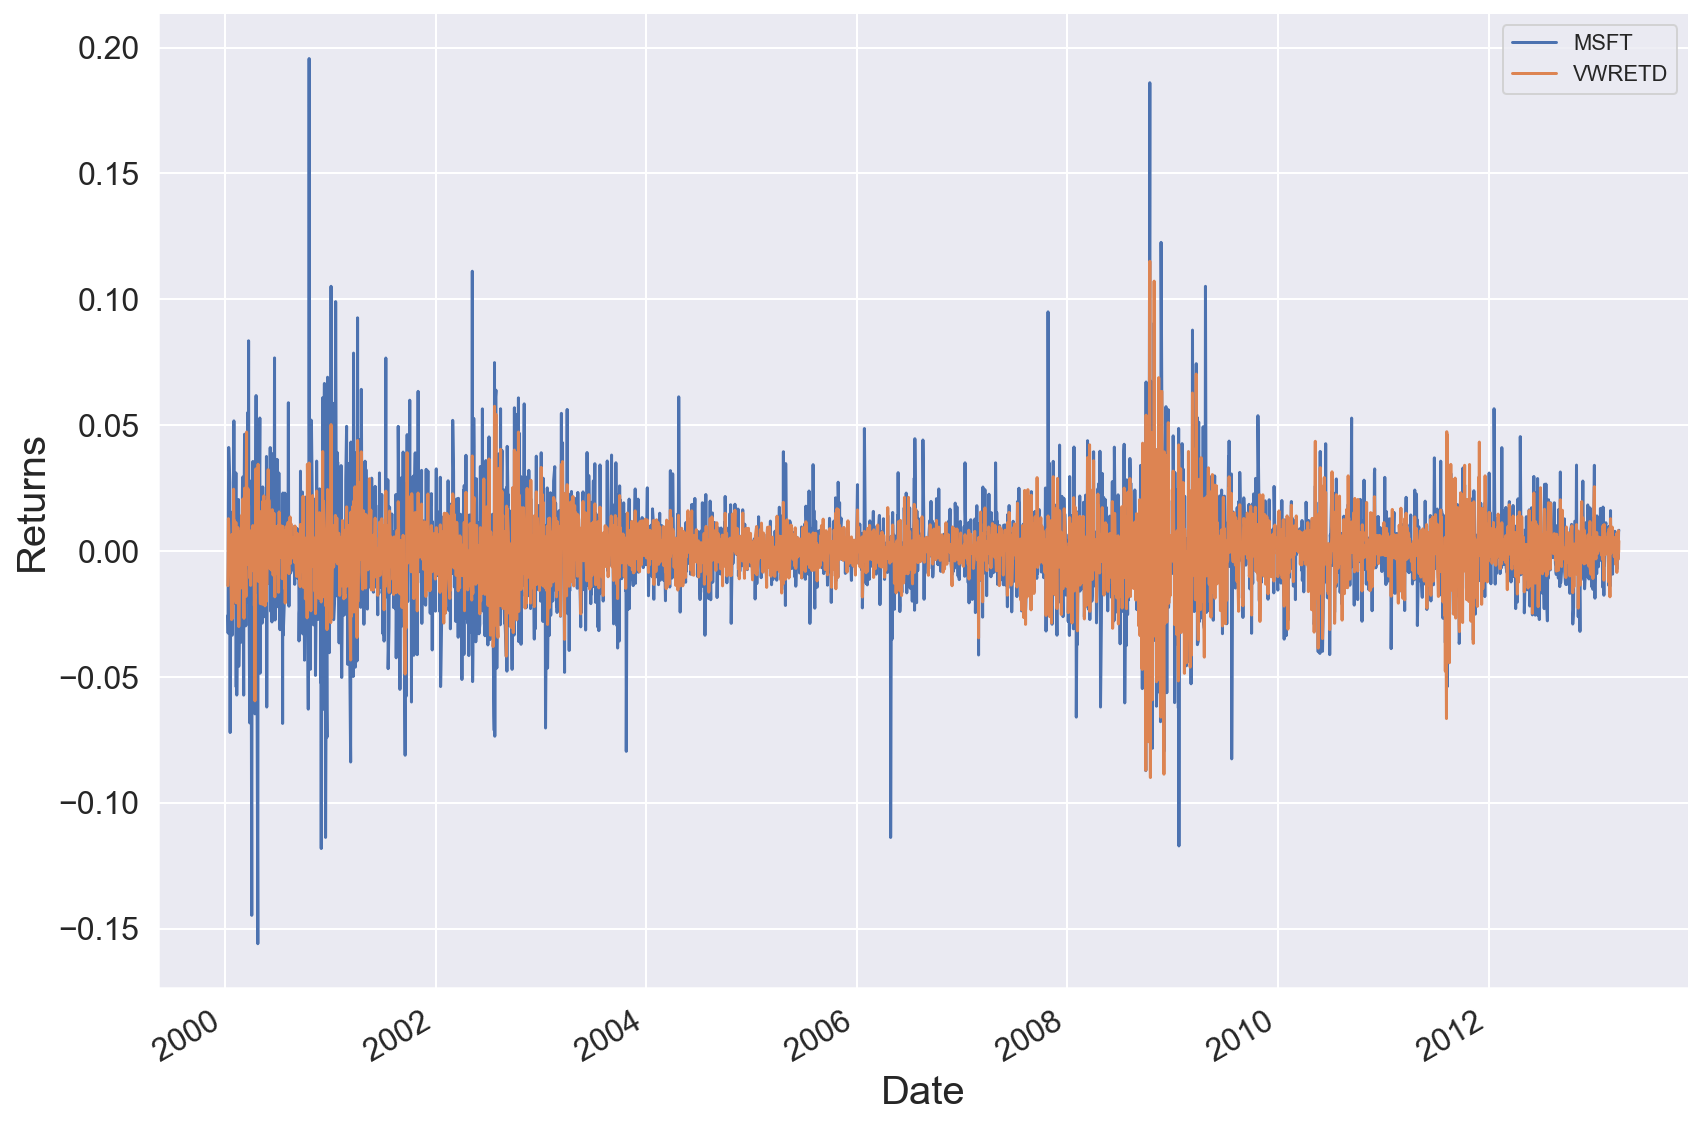

In [8]:
#Let's inspect some time series as an example:
fig,ax = plt.subplots(figsize=(12,8))
_ = daily_df.MSFT.plot(ax = ax)
_ = daily_df.VWRETD.plot(ax = ax)
_ = plt.xlabel('Date')
_ = plt.ylabel('Returns')
_ = plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

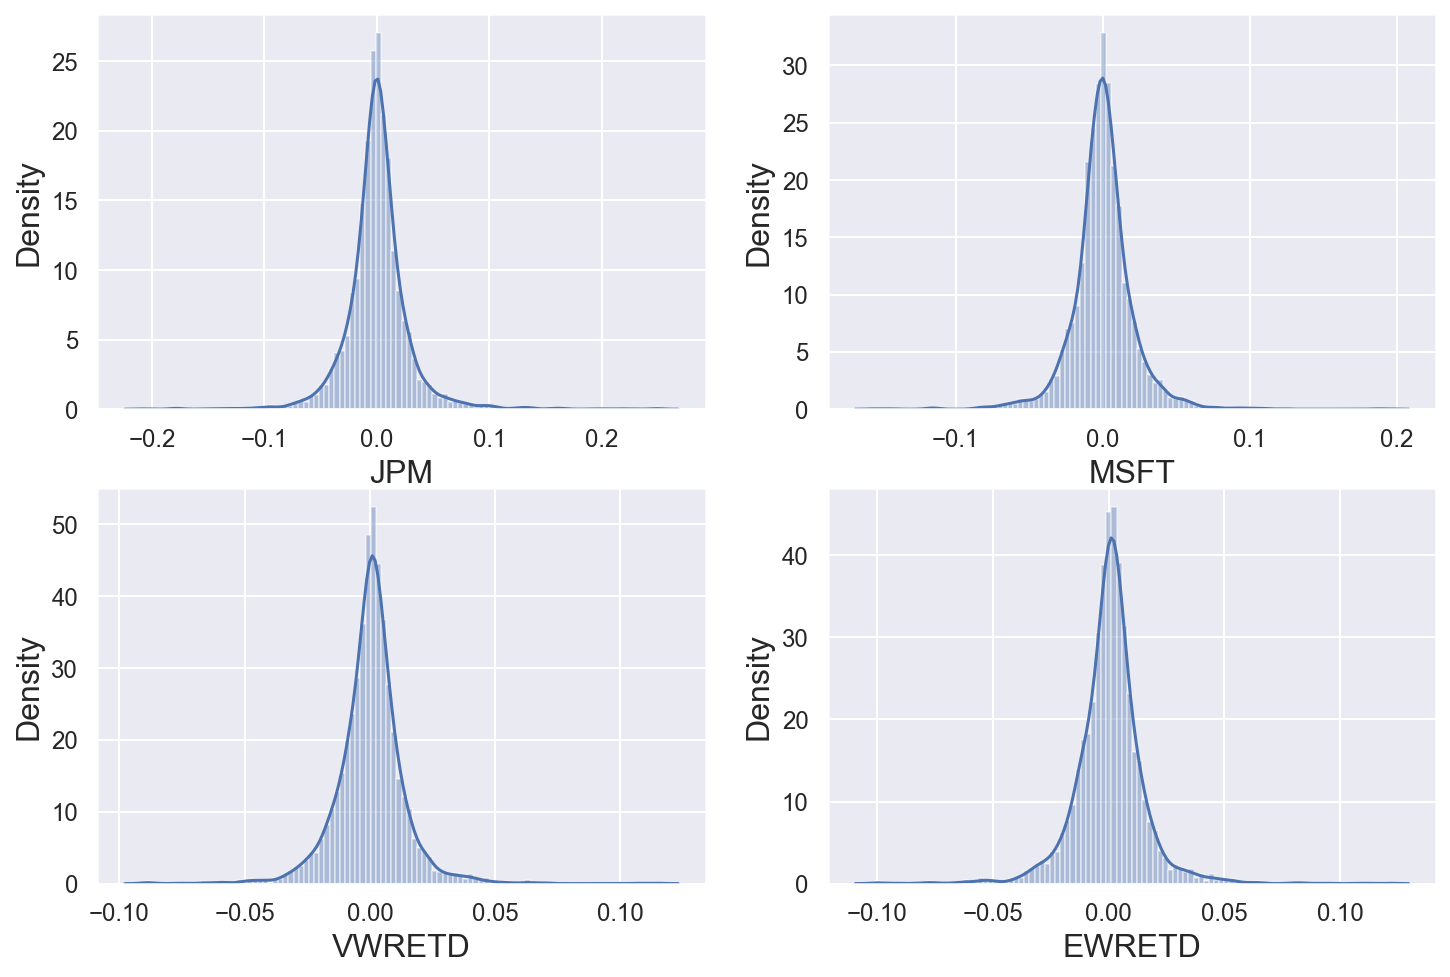

In [77]:
#Let's inspect distributions for outliers
fig, ax = plt.subplots(2,2,figsize=(12,8))
fig1 = sns.distplot(daily_df["JPM"],bins=100, ax= ax[0][0])
fig2 = sns.distplot(daily_df["MSFT"],bins=100, ax=ax[0][1])
fig3 = sns.distplot(daily_df["VWRETD"],bins=100, ax=ax[1][0])
fig4 = sns.distplot(daily_df["EWRETD"],bins=100, ax=ax[1][1])


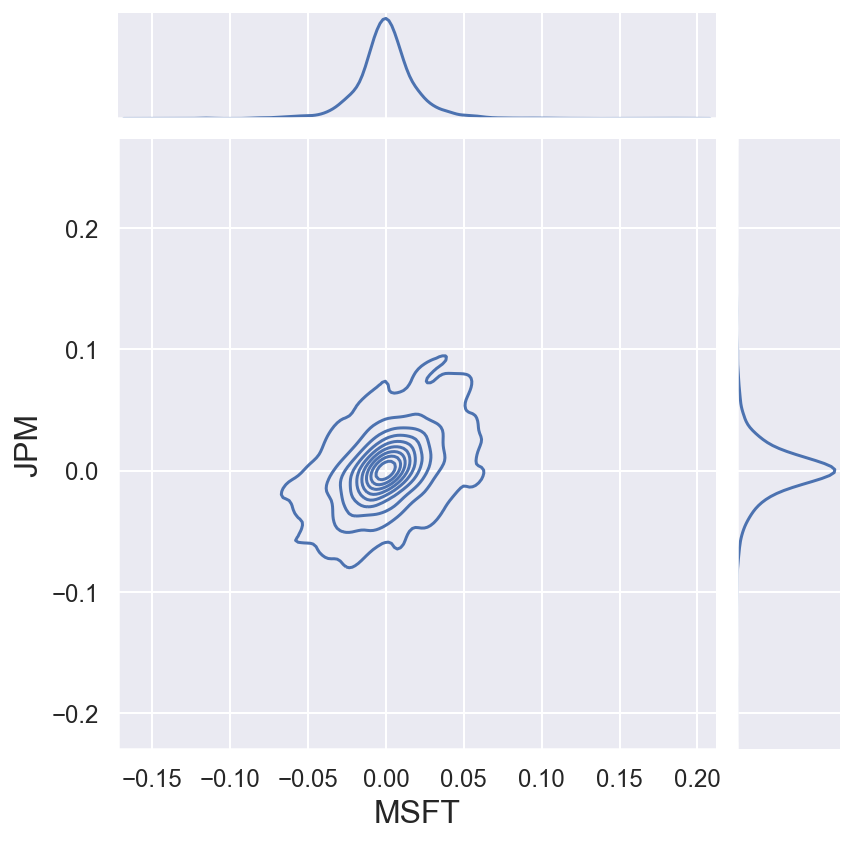

In [74]:
#Let's also inspect joint distributions:
sns.jointplot(data = daily_df, x = "MSFT", y = "JPM", kind='kde') #here kde means kernel density plots

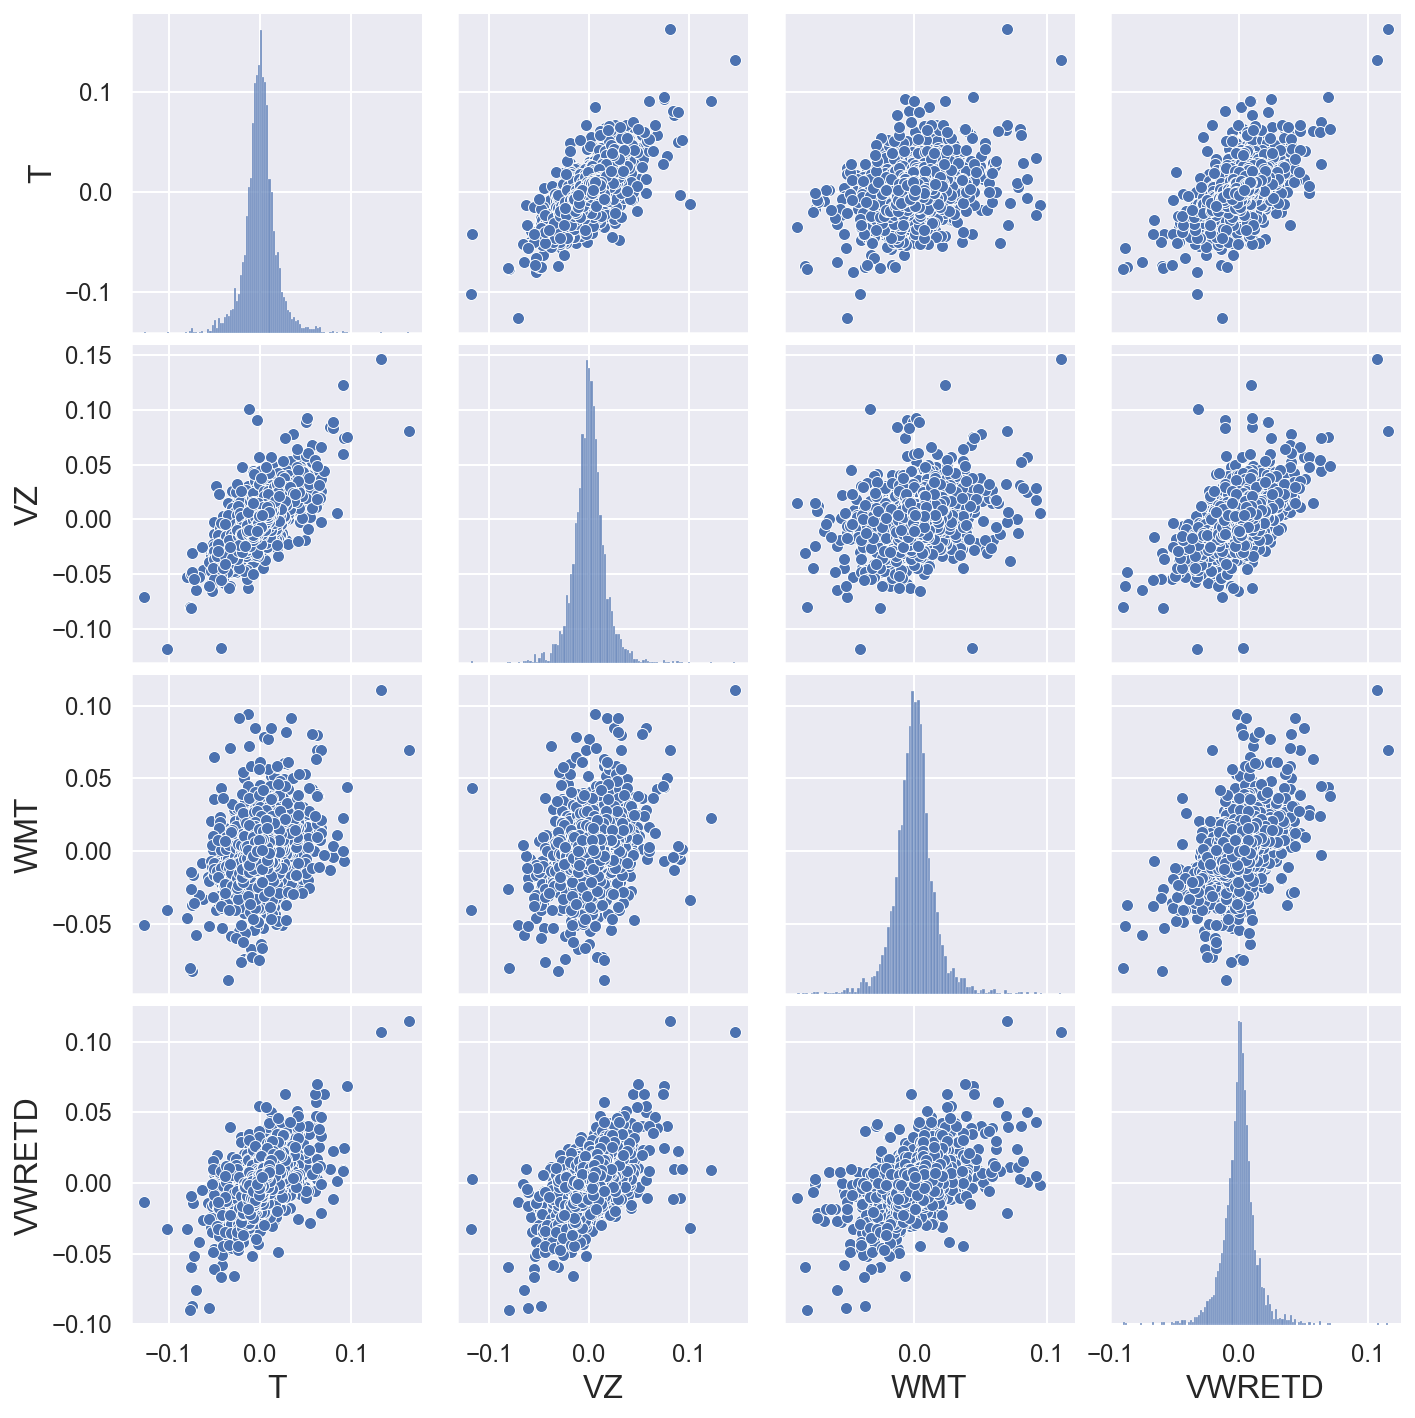

In [79]:
#Finally, let's inspect the scatter matrix plot for some of the tickers to understand the data structure better
sns.pairplot(daily_df.loc[:,['T','VZ','WMT','VWRETD']])

_Note:_ interesting to observe that VZ and T, two companies of the same sector exhibit a higher degree of co-movement (straighter scatter plot lines) than VZ and WMT for instance.

#### Part 1

Now that we inspected the data, we can proceed with answering the questions.

In [12]:
#Let's review the main statistics of the returns:
stats = pd.concat({'mean':daily_df.mean(axis=0),'std':daily_df.std(axis=0),'autocorr':daily_df.apply(lambda s: s.autocorr(lag=1))},axis=1)
stats

mean       std  autocorr
AIG    -0.000037  0.043796  0.134600
AXP     0.000494  0.025470 -0.068588
BA      0.000493  0.020422 -0.011943
DD      0.000218  0.019074 -0.035077
DIS     0.000406  0.020970 -0.040681
HD      0.000347  0.021970  0.016098
HPQ     0.000189  0.025477 -0.015097
IBM     0.000382  0.017711 -0.049531
JPM     0.000515  0.028367 -0.084815
MCD     0.000493  0.016110 -0.021483
MRK     0.000192  0.018803  0.007716
MSFT    0.000099  0.020840 -0.047805
T       0.000289  0.018124 -0.008823
VZ      0.000304  0.017239 -0.029420
WMT     0.000223  0.016274 -0.035346
VWRETD  0.000190  0.013351 -0.085815
EWRETD  0.000439  0.014713 -0.042037

Let's split the time period in 4 subperiods and create separate stats for each

In [13]:
date_split = np.array_split(daily_df.index.values,4)
for i, d_split in enumerate(date_split):
    daily_df.loc[d_split,'SubGroup'] = i+1
daily_df.loc[:,'SubGroup'] = daily_df.SubGroup.astype(int)
daily_df = daily_df.set_index('SubGroup',append=True)

In [14]:
[(np.datetime_as_string(d.min(),'D'),np.datetime_as_string(d.max(),'D')) for d in date_split]

[('2000-01-11', '2003-05-05'),
 ('2003-05-06', '2006-08-21'),
 ('2006-08-22', '2009-12-08'),
 ('2009-12-09', '2013-03-28')]

In [15]:
def sub_group_stats(df):
    return pd.concat({'mean':df.mean(axis=0),'std':df.std(axis=0),'autocorr':df.apply(lambda s: s.autocorr(lag=1))},axis=1)
sub_group_stats = daily_df.groupby('SubGroup').apply(sub_group_stats)

Let's plot the stats for the stocks and the indexes separately for the various subgroups. It is clear the statistics for stocks vary quite a bit over time. The outlier is AIG in the period that includes 2008 (majorly impacted by the subprime crisis and which had to be bailed out). The indices are more stable, the power of averaging!

<AxesSubplot:xlabel='SubGroup'>

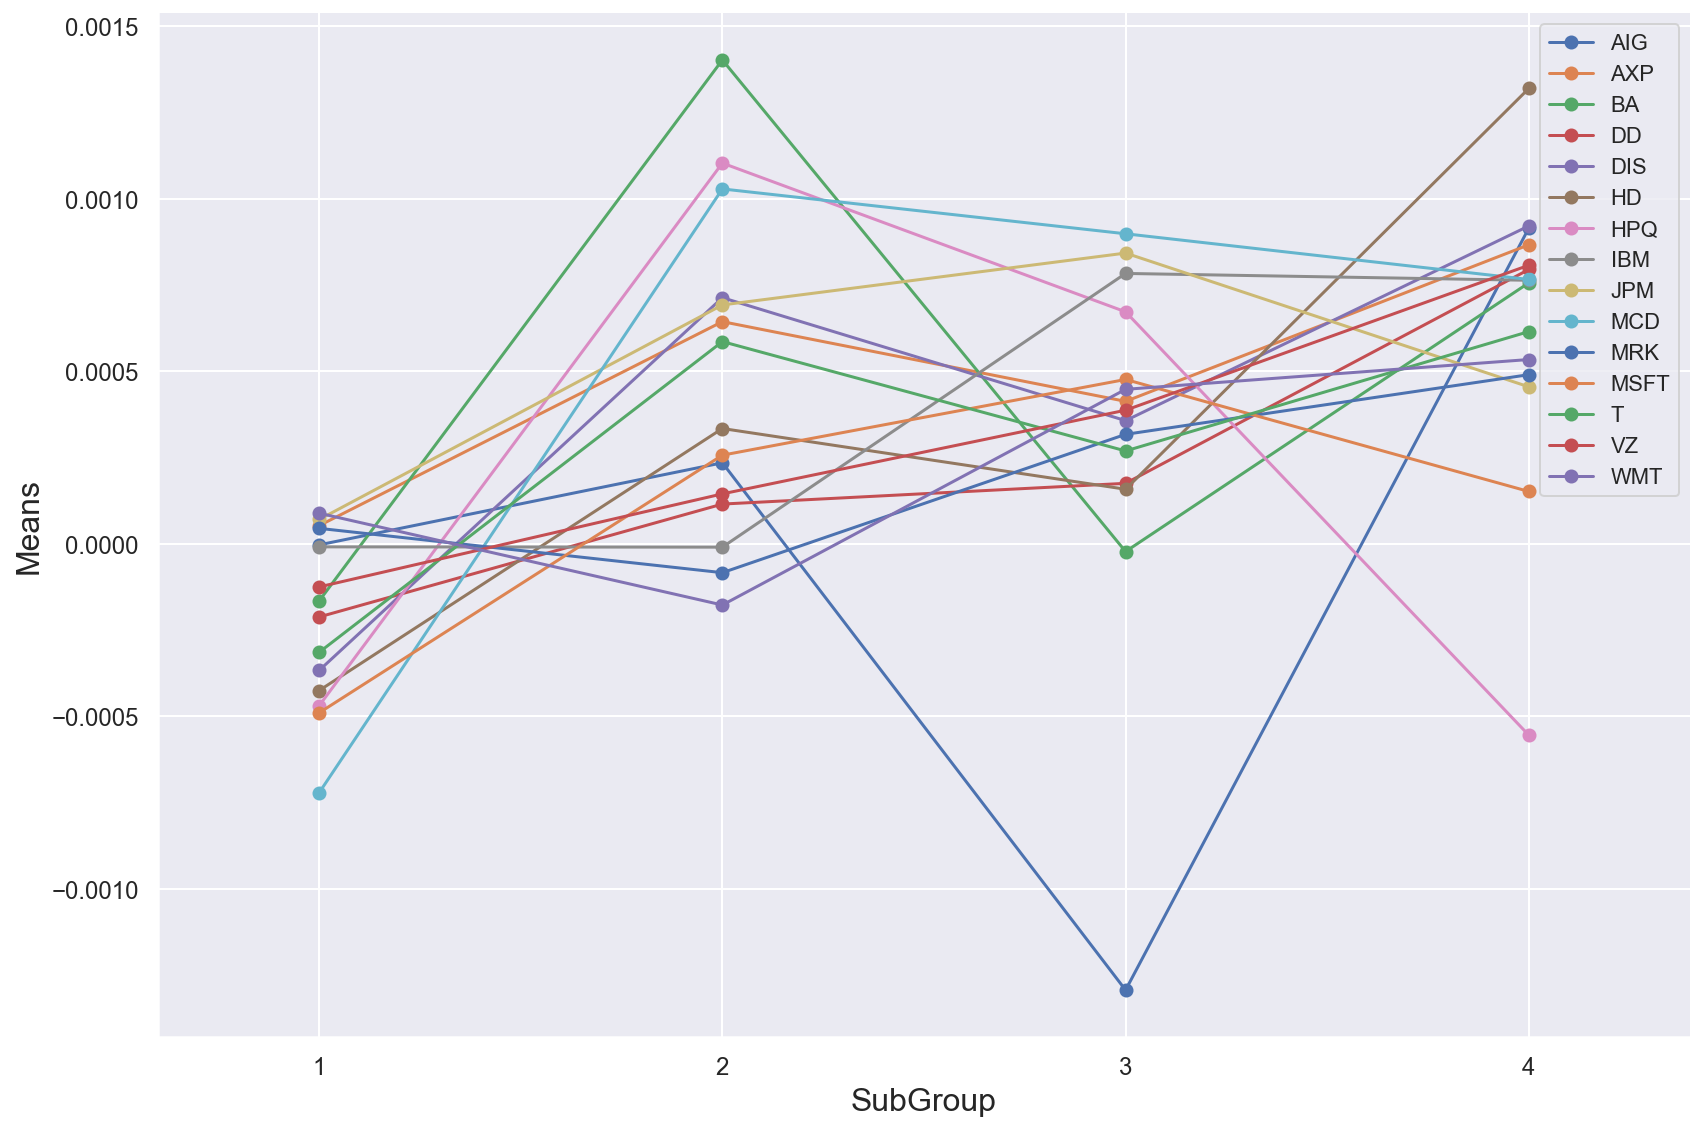

In [81]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'mean'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Means')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='SubGroup'>

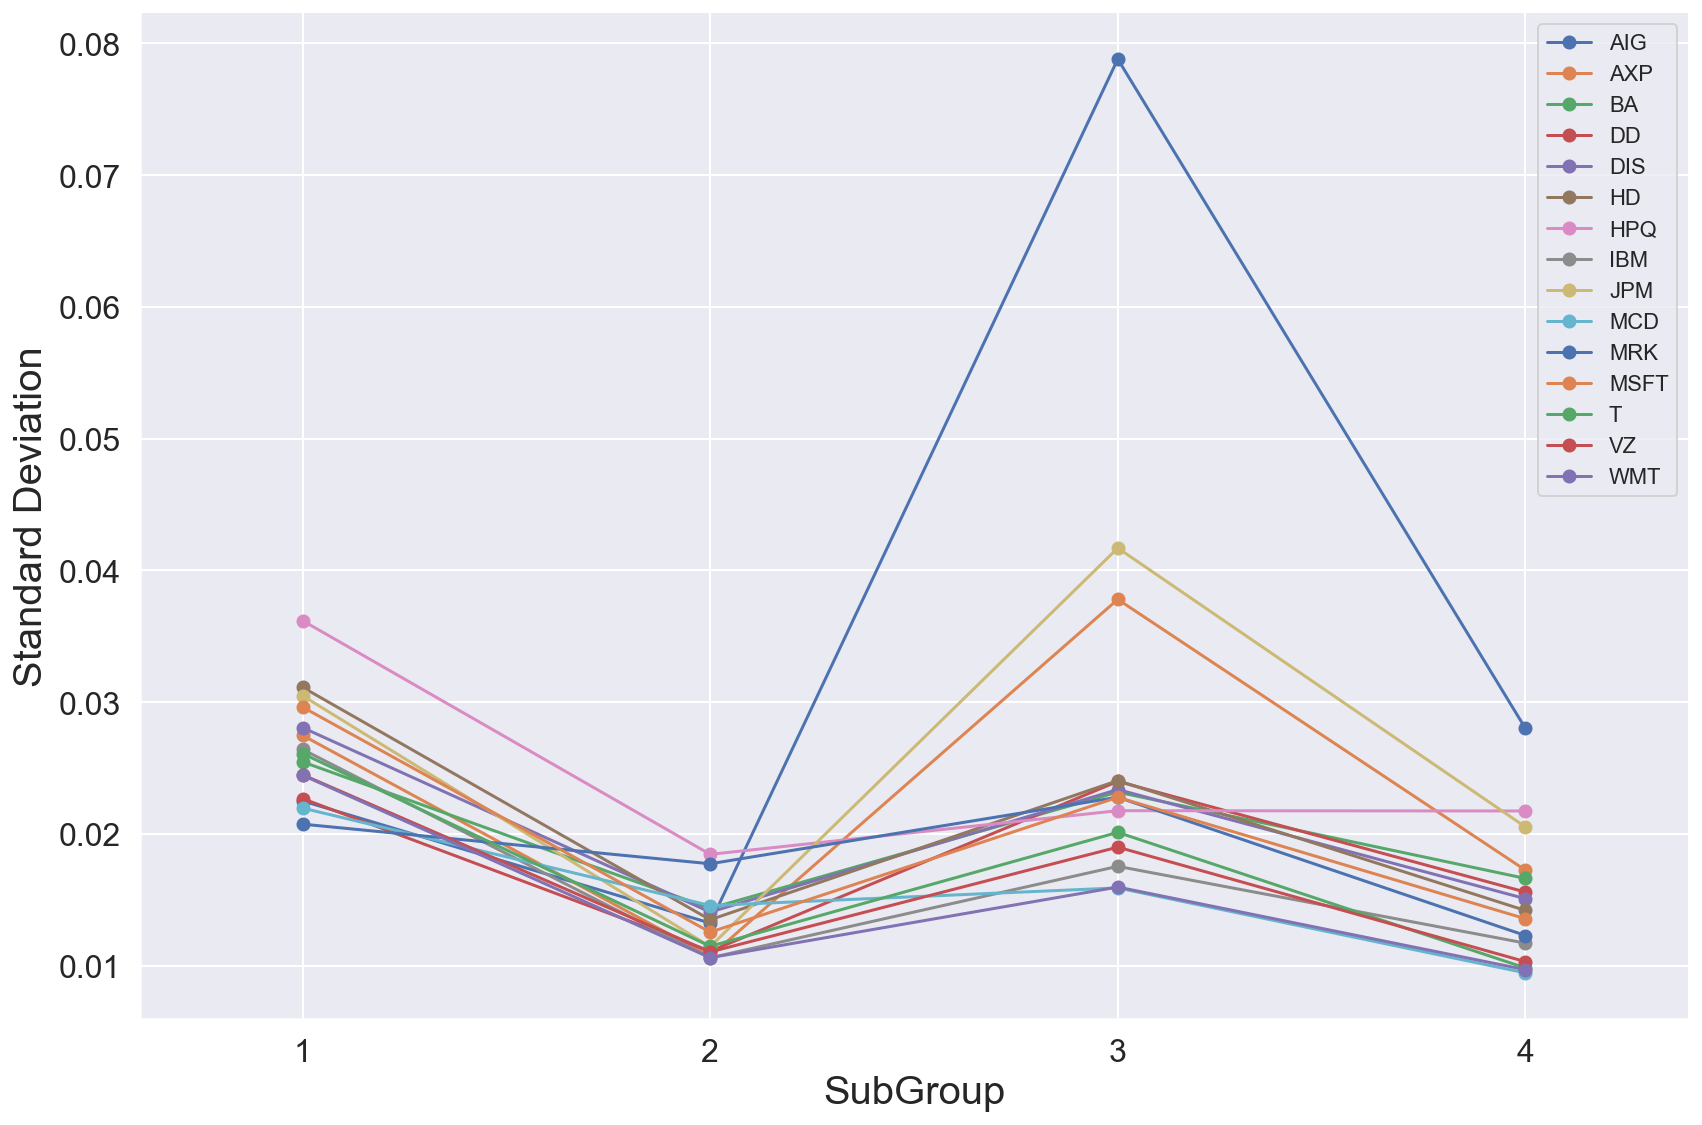

In [17]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'std'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Standard Deviation')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

_Note:_ Unsurprisingly, the third SubGroup containing the GFC period sees a significant jump in StDev for the three financial companies in the sample: AIG, JPM and AXP

<AxesSubplot:xlabel='SubGroup'>

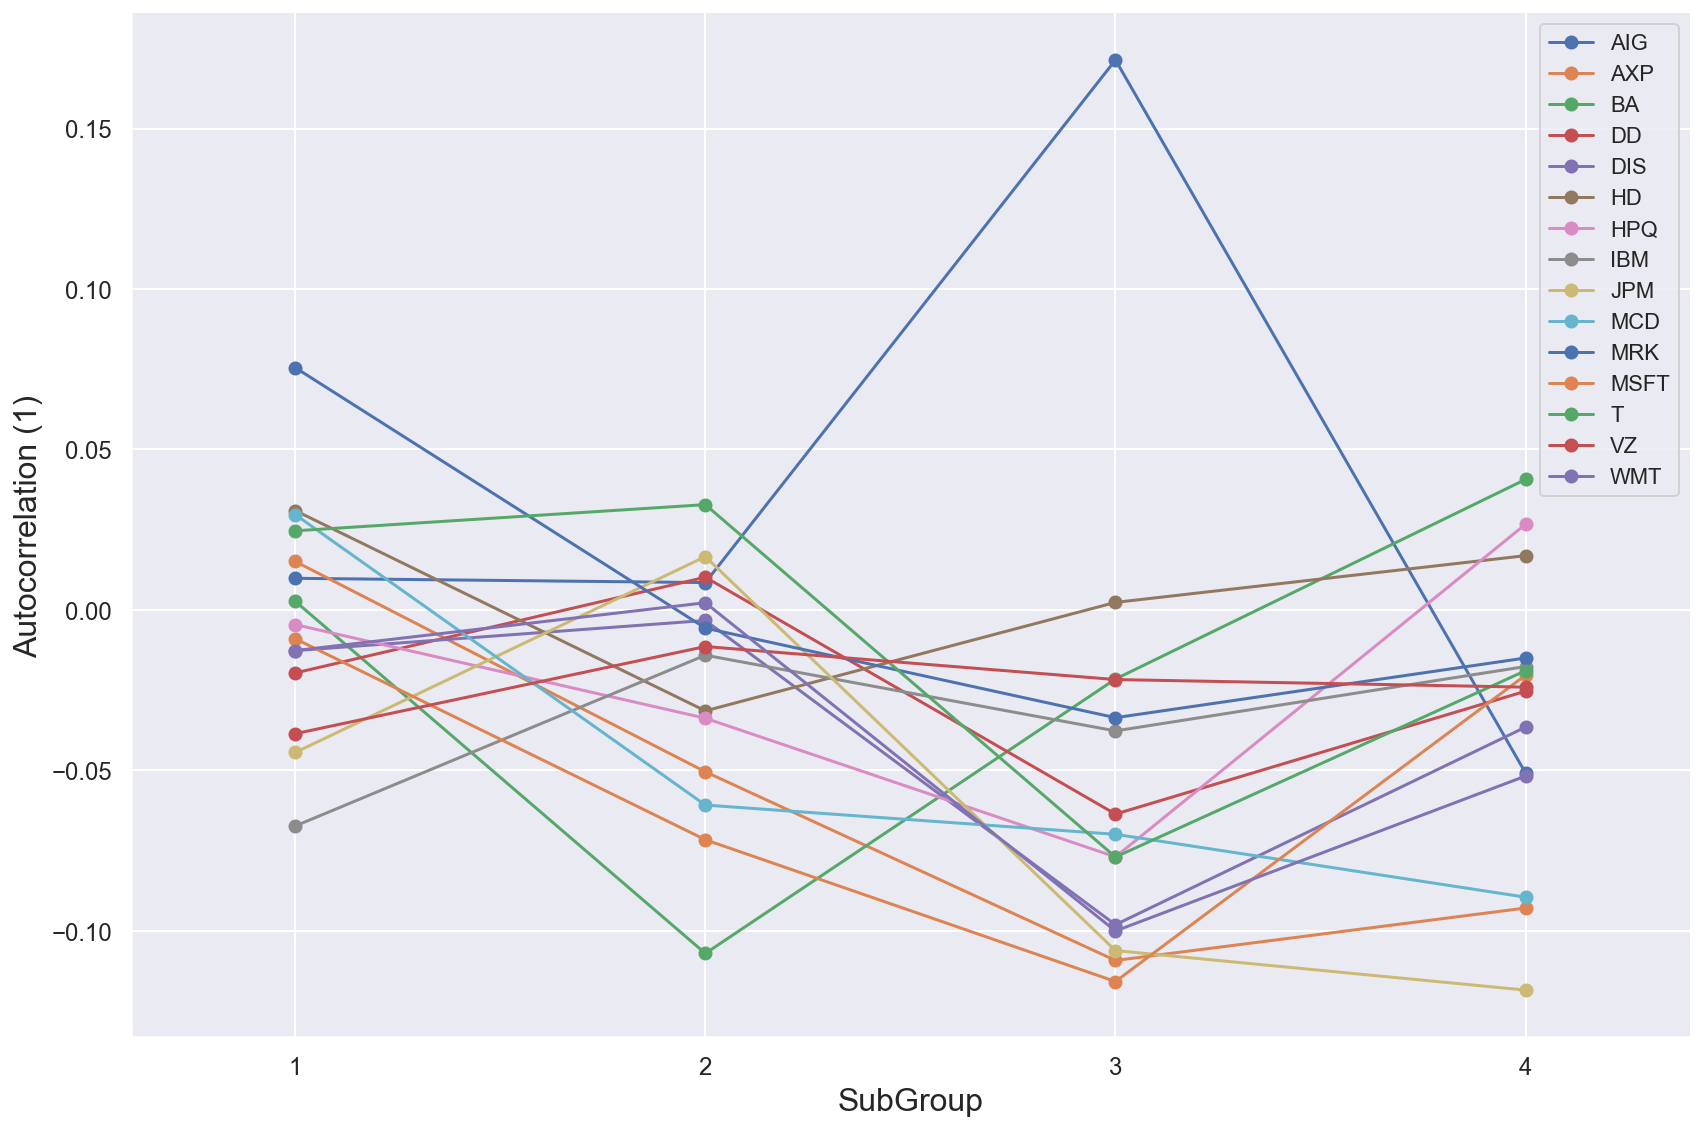

In [82]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'autocorr'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Autocorrelation (1)')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='SubGroup'>

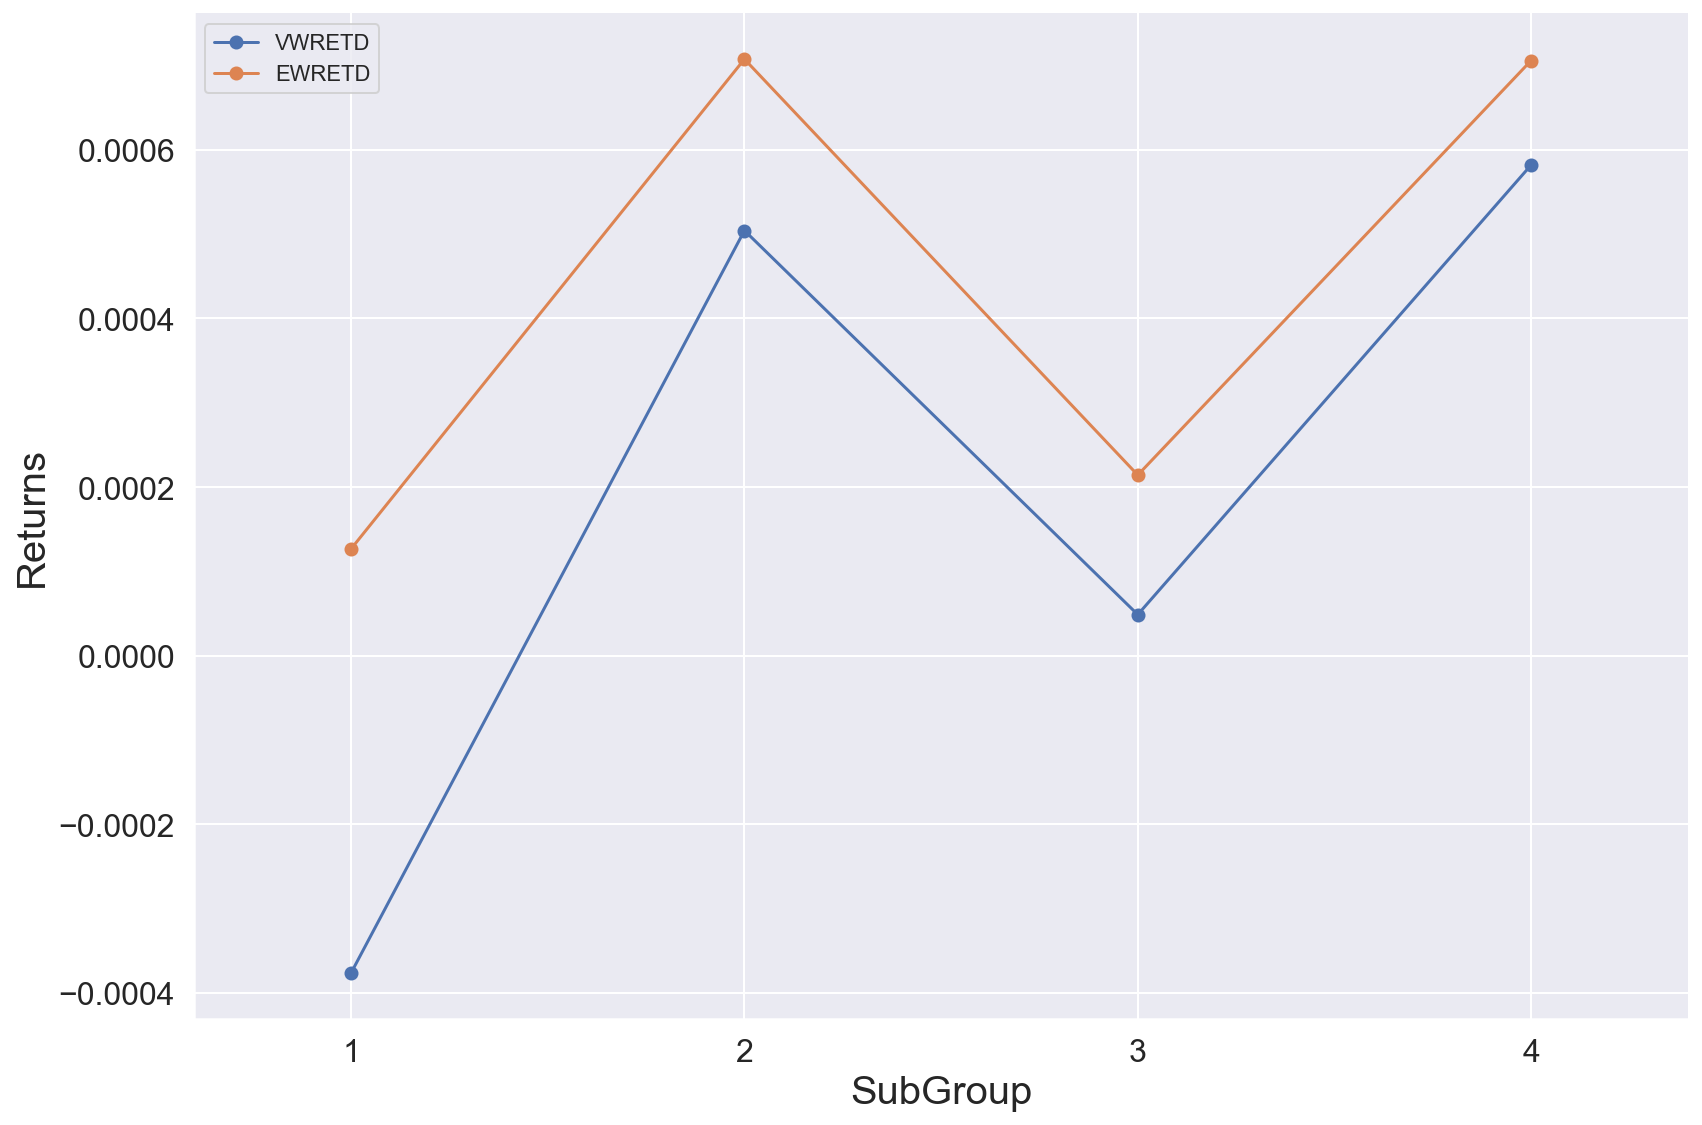

In [19]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'mean'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Returns')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='SubGroup'>

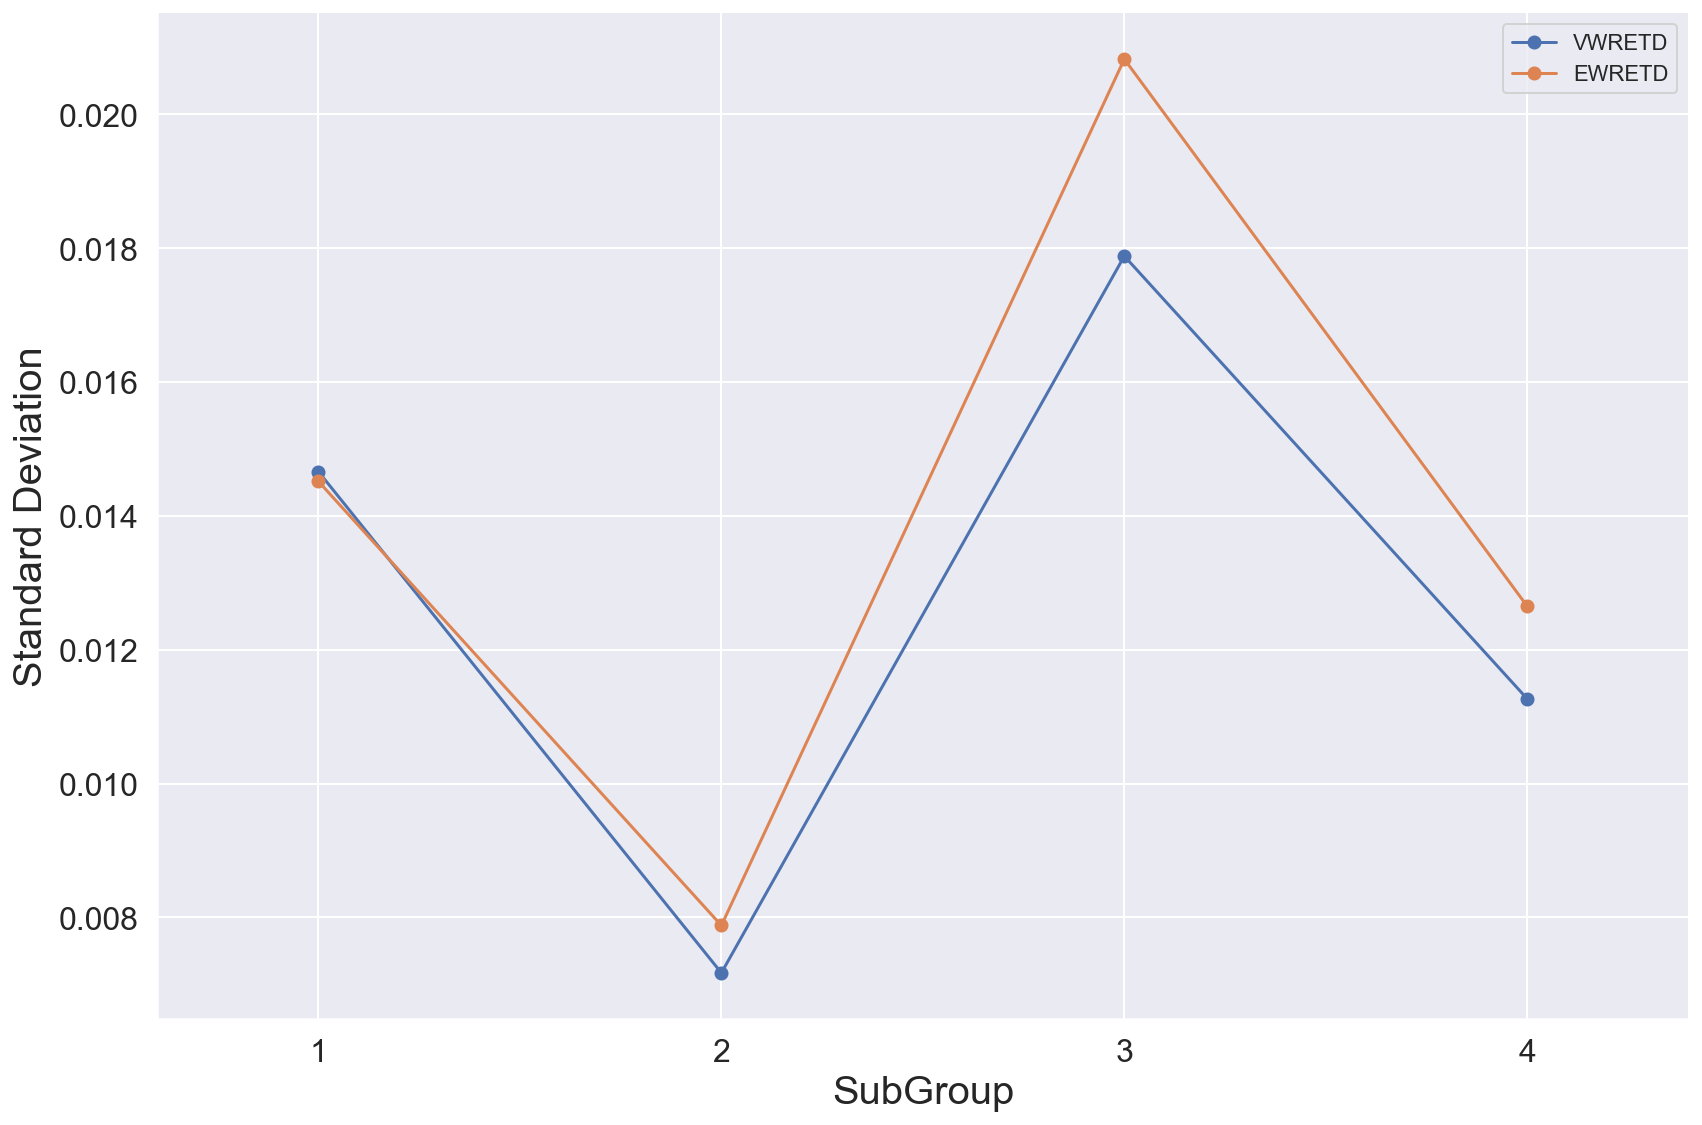

In [20]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'std'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Standard Deviation')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='SubGroup'>

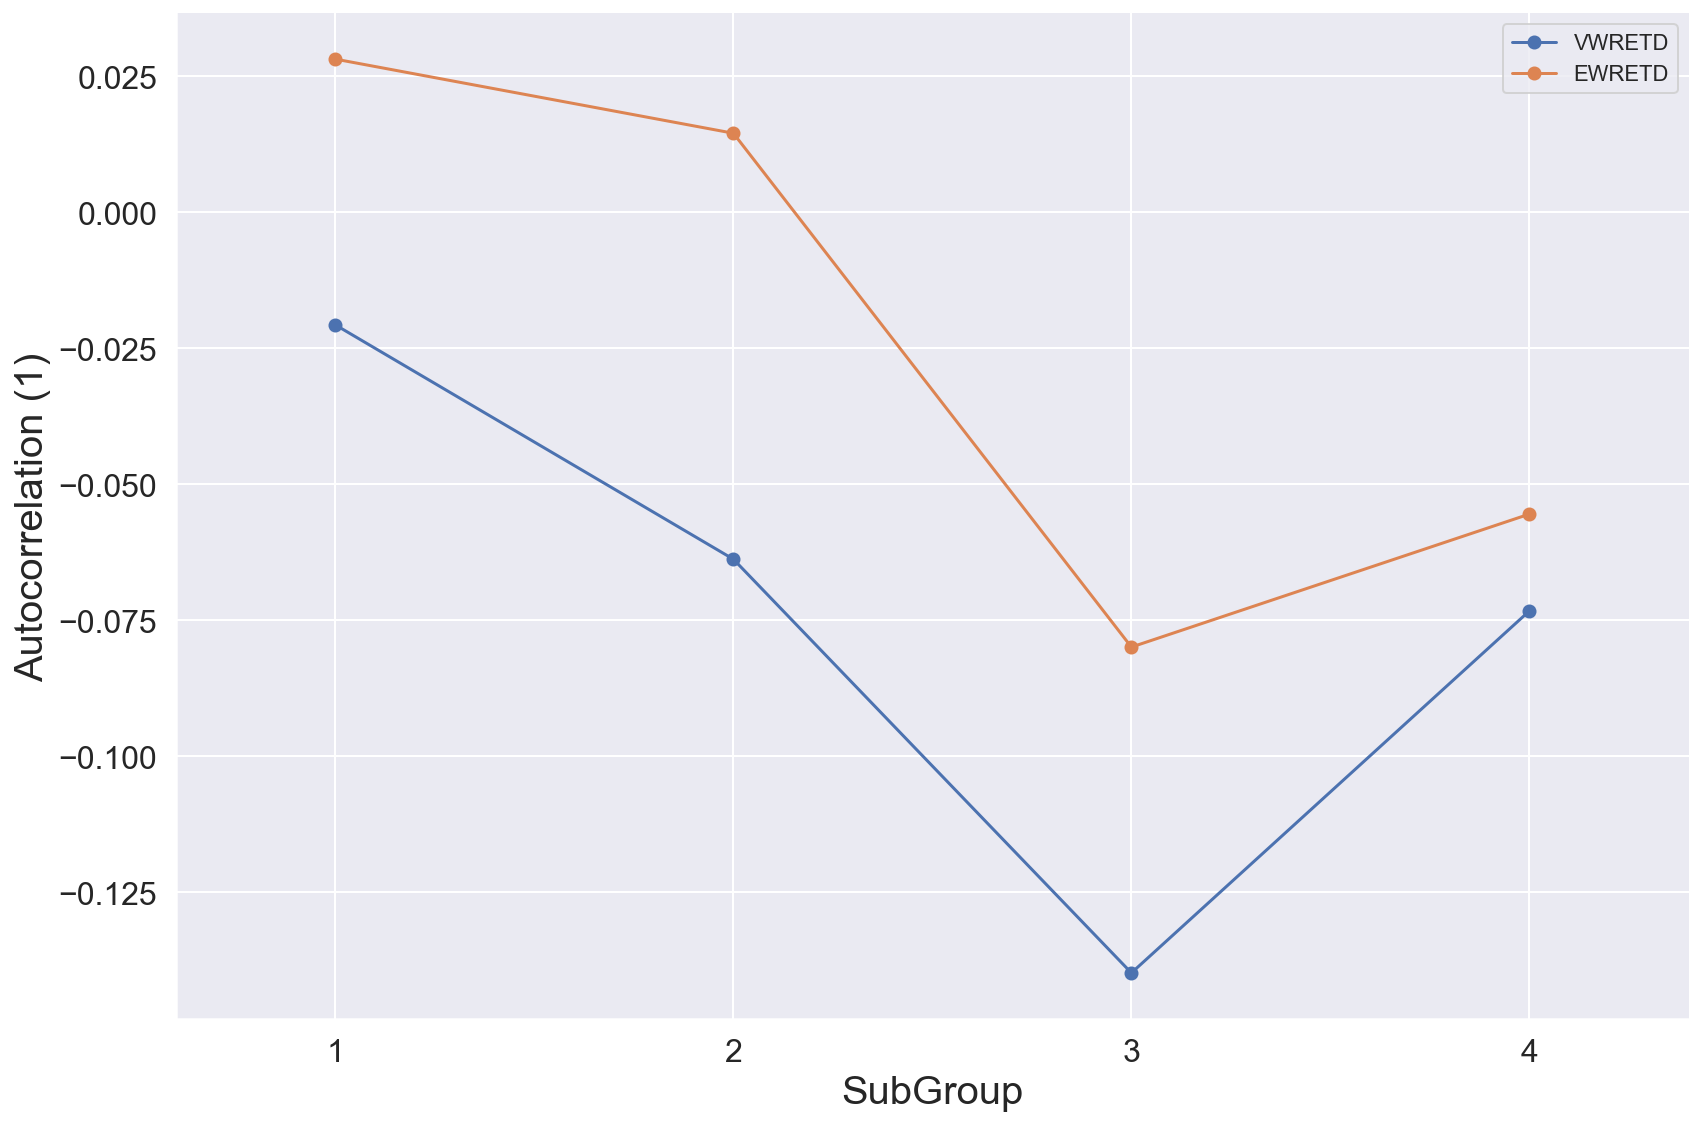

In [21]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'autocorr'].unstack(level=1).plot(ax = ax,marker='o')
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Autocorrelation (1)')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
_ = plt.xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show()

_Note:_ While most individual stocks exhibit negative autocorrelations, the indexes exhibit higher negative autocorrelations, in particular during the GFC period.

#### Part 2

In [84]:
means = d_indexes.mean(axis=0)
stds = d_indexes.std(axis=0)
n_points = d_indexes.shape[0]
idx_1 = pd.Series(np.random.normal(means[0],stds[0],n_points),name='Normal')
idx_2 = pd.Series(np.random.normal(means[1],stds[1],n_points),name='Normal')
means.head()


VWRETD    0.000187
EWRETD    0.000437
dtype: float64

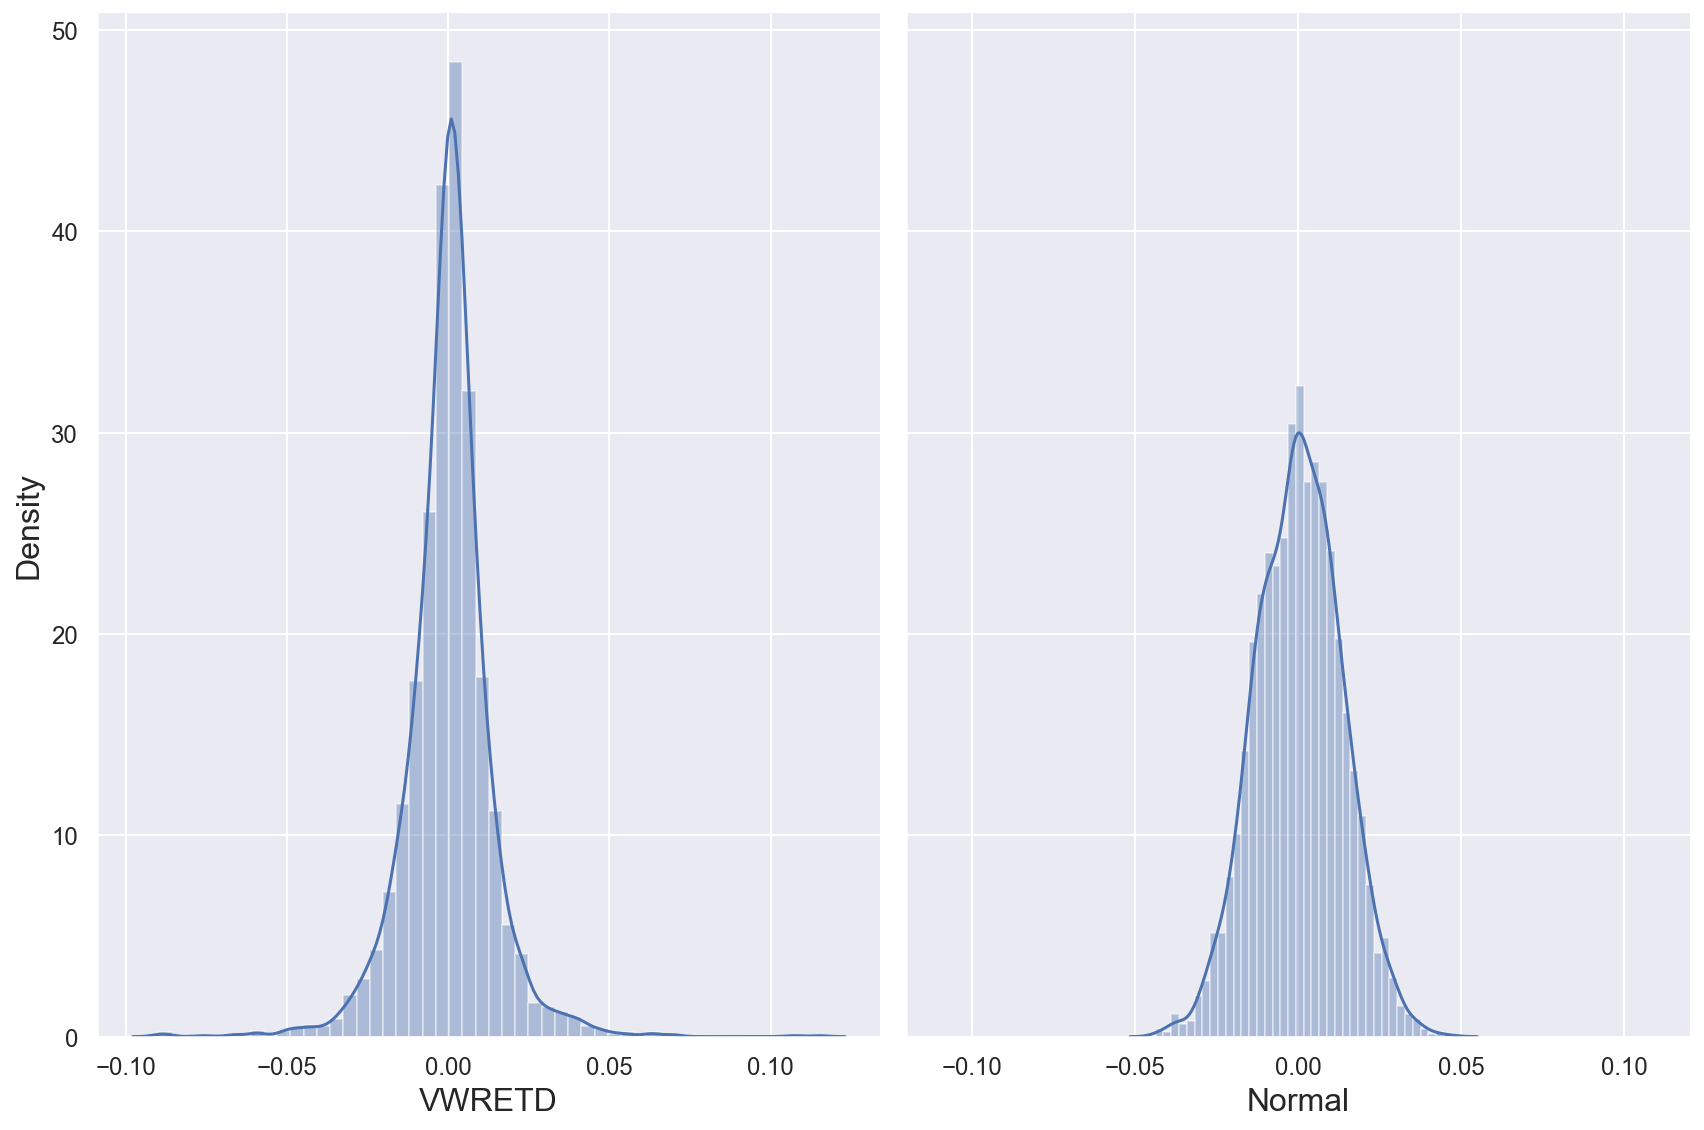

In [85]:
#Let's inspect the distributions and compare to a Normal
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(d_indexes.VWRETD, ax=ax1)
_ = sns.distplot(idx_1, ax=ax2)
_ = plt.ylabel('Density')
_ = plt.xlim(-0.12, 0.12)
sns.despine()
plt.tight_layout()
plt.show()

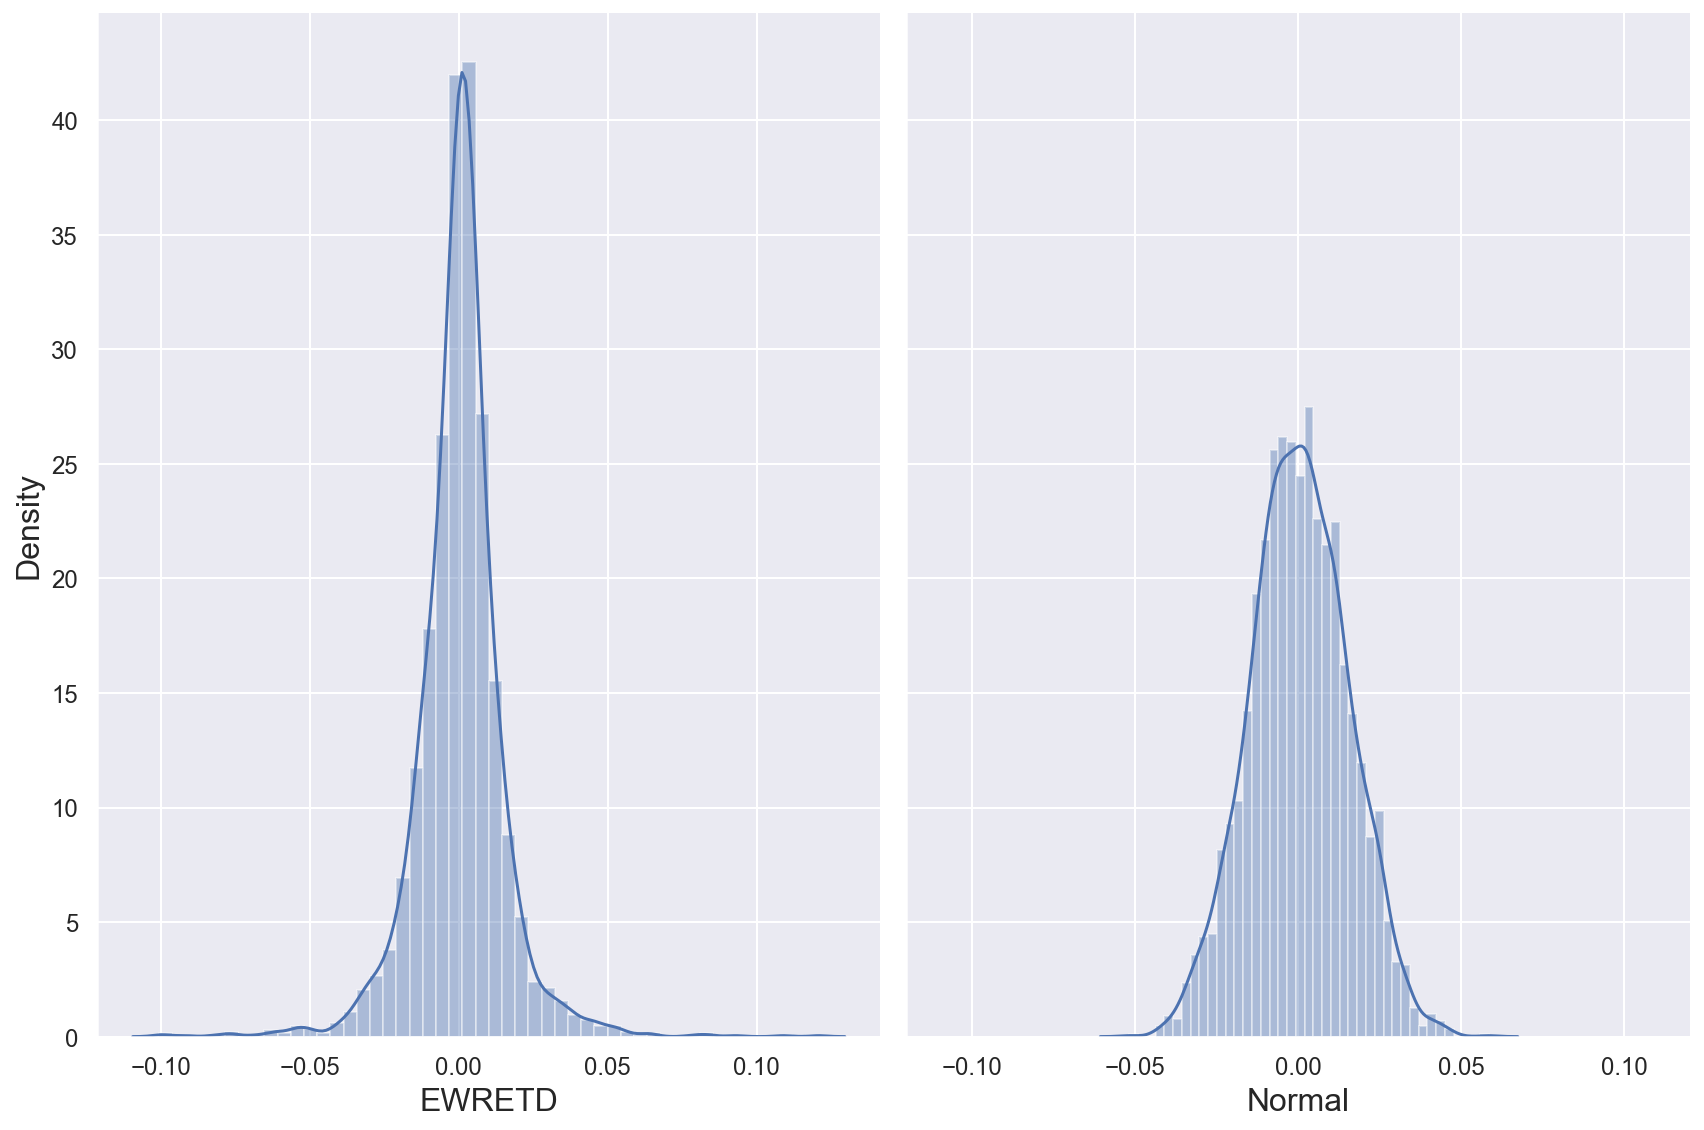

In [86]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(d_indexes.EWRETD,ax=ax1)
_ = sns.distplot(idx_2,ax=ax2)
_ = plt.ylabel('Density')
_ = plt.xlim(-0.12, 0.12)
sns.despine()
plt.tight_layout()
plt.show()

Neither distribution of returns looks Normal but the equally weighted index looks definitively more normal than the value (cap weighted) index. Worth noting that the indexes return distributions differ from the normal, in particular as they are leptokurtic.

#### Part 3

To calculate confidence intervals of the mean a good package is the statsmodel package using the DescrStatsW function to get descriptive statistics. One of the outputs it **tconfint_mean** function.
Let's create a function we can apply for every column to create the structure we need

In [25]:
#99% Confidence Interval function
def calc_confidence_interval(x):
    ci = DescrStatsW(x).tconfint_mean(alpha=0.01)
    mean = x.mean()
    return pd.Series({'lower_bound':ci[0], 'mean':mean, 'upper_bound':ci[1]})

In [26]:
conf_interval = daily_df.apply(calc_confidence_interval).T
conf_interval

lower_bound      mean  upper_bound
AIG       -0.001995 -0.000037     0.001921
AXP       -0.000645  0.000494     0.001633
BA        -0.000420  0.000493     0.001406
DD        -0.000634  0.000218     0.001071
DIS       -0.000531  0.000406     0.001344
HD        -0.000636  0.000347     0.001329
HPQ       -0.000951  0.000189     0.001328
IBM       -0.000409  0.000382     0.001174
JPM       -0.000753  0.000515     0.001784
MCD       -0.000227  0.000493     0.001213
MRK       -0.000648  0.000192     0.001033
MSFT      -0.000833  0.000099     0.001031
T         -0.000521  0.000289     0.001099
VZ        -0.000467  0.000304     0.001074
WMT       -0.000504  0.000223     0.000951
VWRETD    -0.000407  0.000190     0.000787
EWRETD    -0.000219  0.000439     0.001096

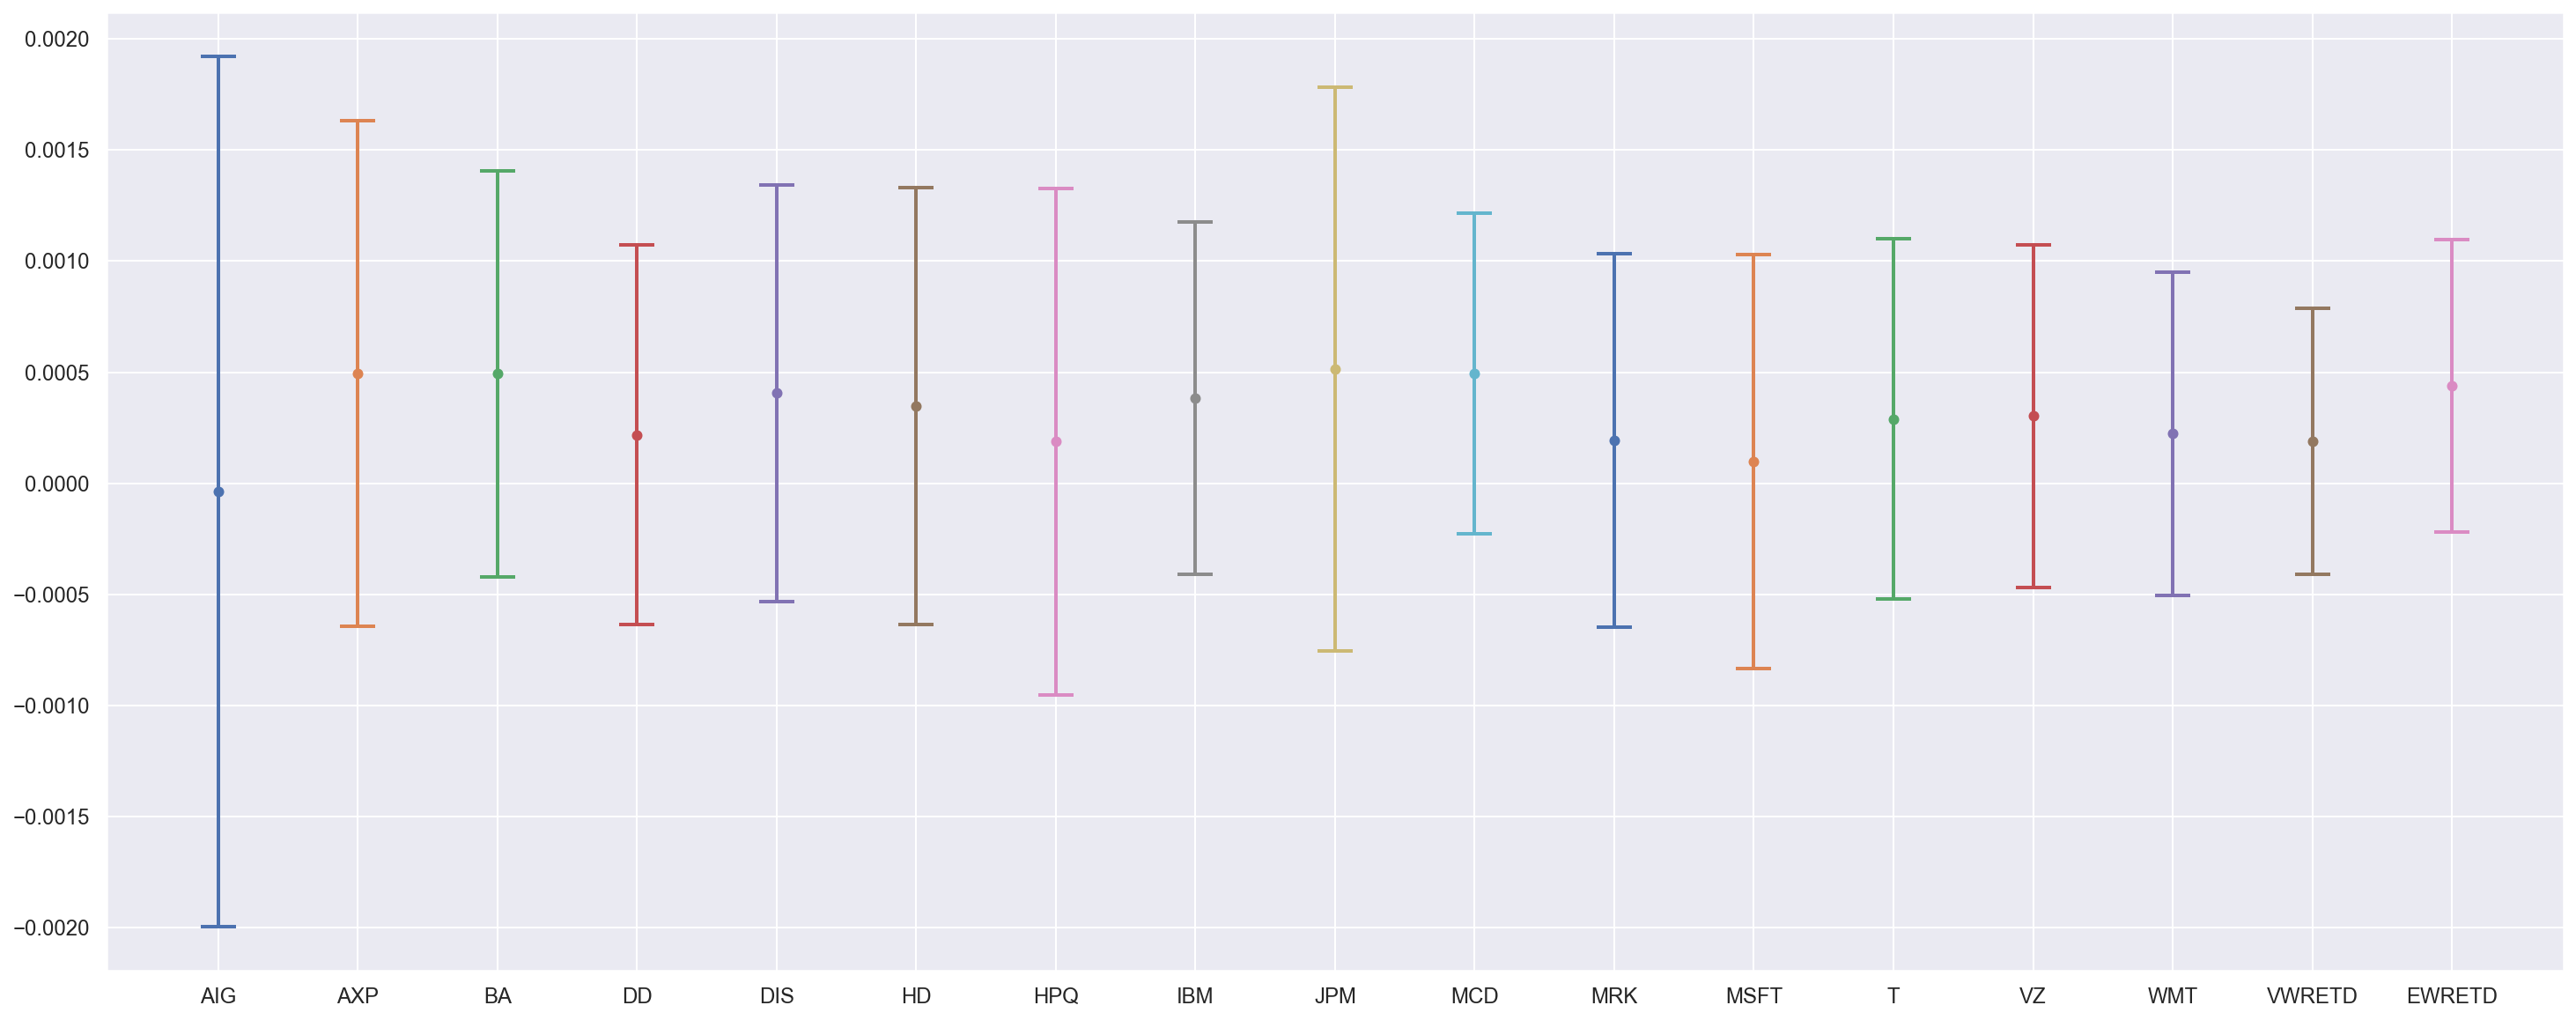

In [91]:
fig,ax = plt.subplots(figsize=(25,10))
for i in range(17):
    colors = sns.color_palette(n_colors= 17)
    entry = conf_interval.iloc[i]
    plt.plot( (i,i),(entry.lower_bound,entry.upper_bound),marker='_',color=cm.colors.to_rgba(colors[i]),linewidth=2.0,markersize=20.0,markeredgewidth=2.0)
    plt.plot(i,entry['mean'],marker='.',c=cm.colors.to_rgba(colors[i]),markersize=10.0)
plt.xticks(ticks=range(17),labels=conf_interval.index)
plt.show();    

In [28]:
conf_interval_subgroup = daily_df.stack().groupby(level=[1,2]).apply(calc_confidence_interval).unstack(level=2)

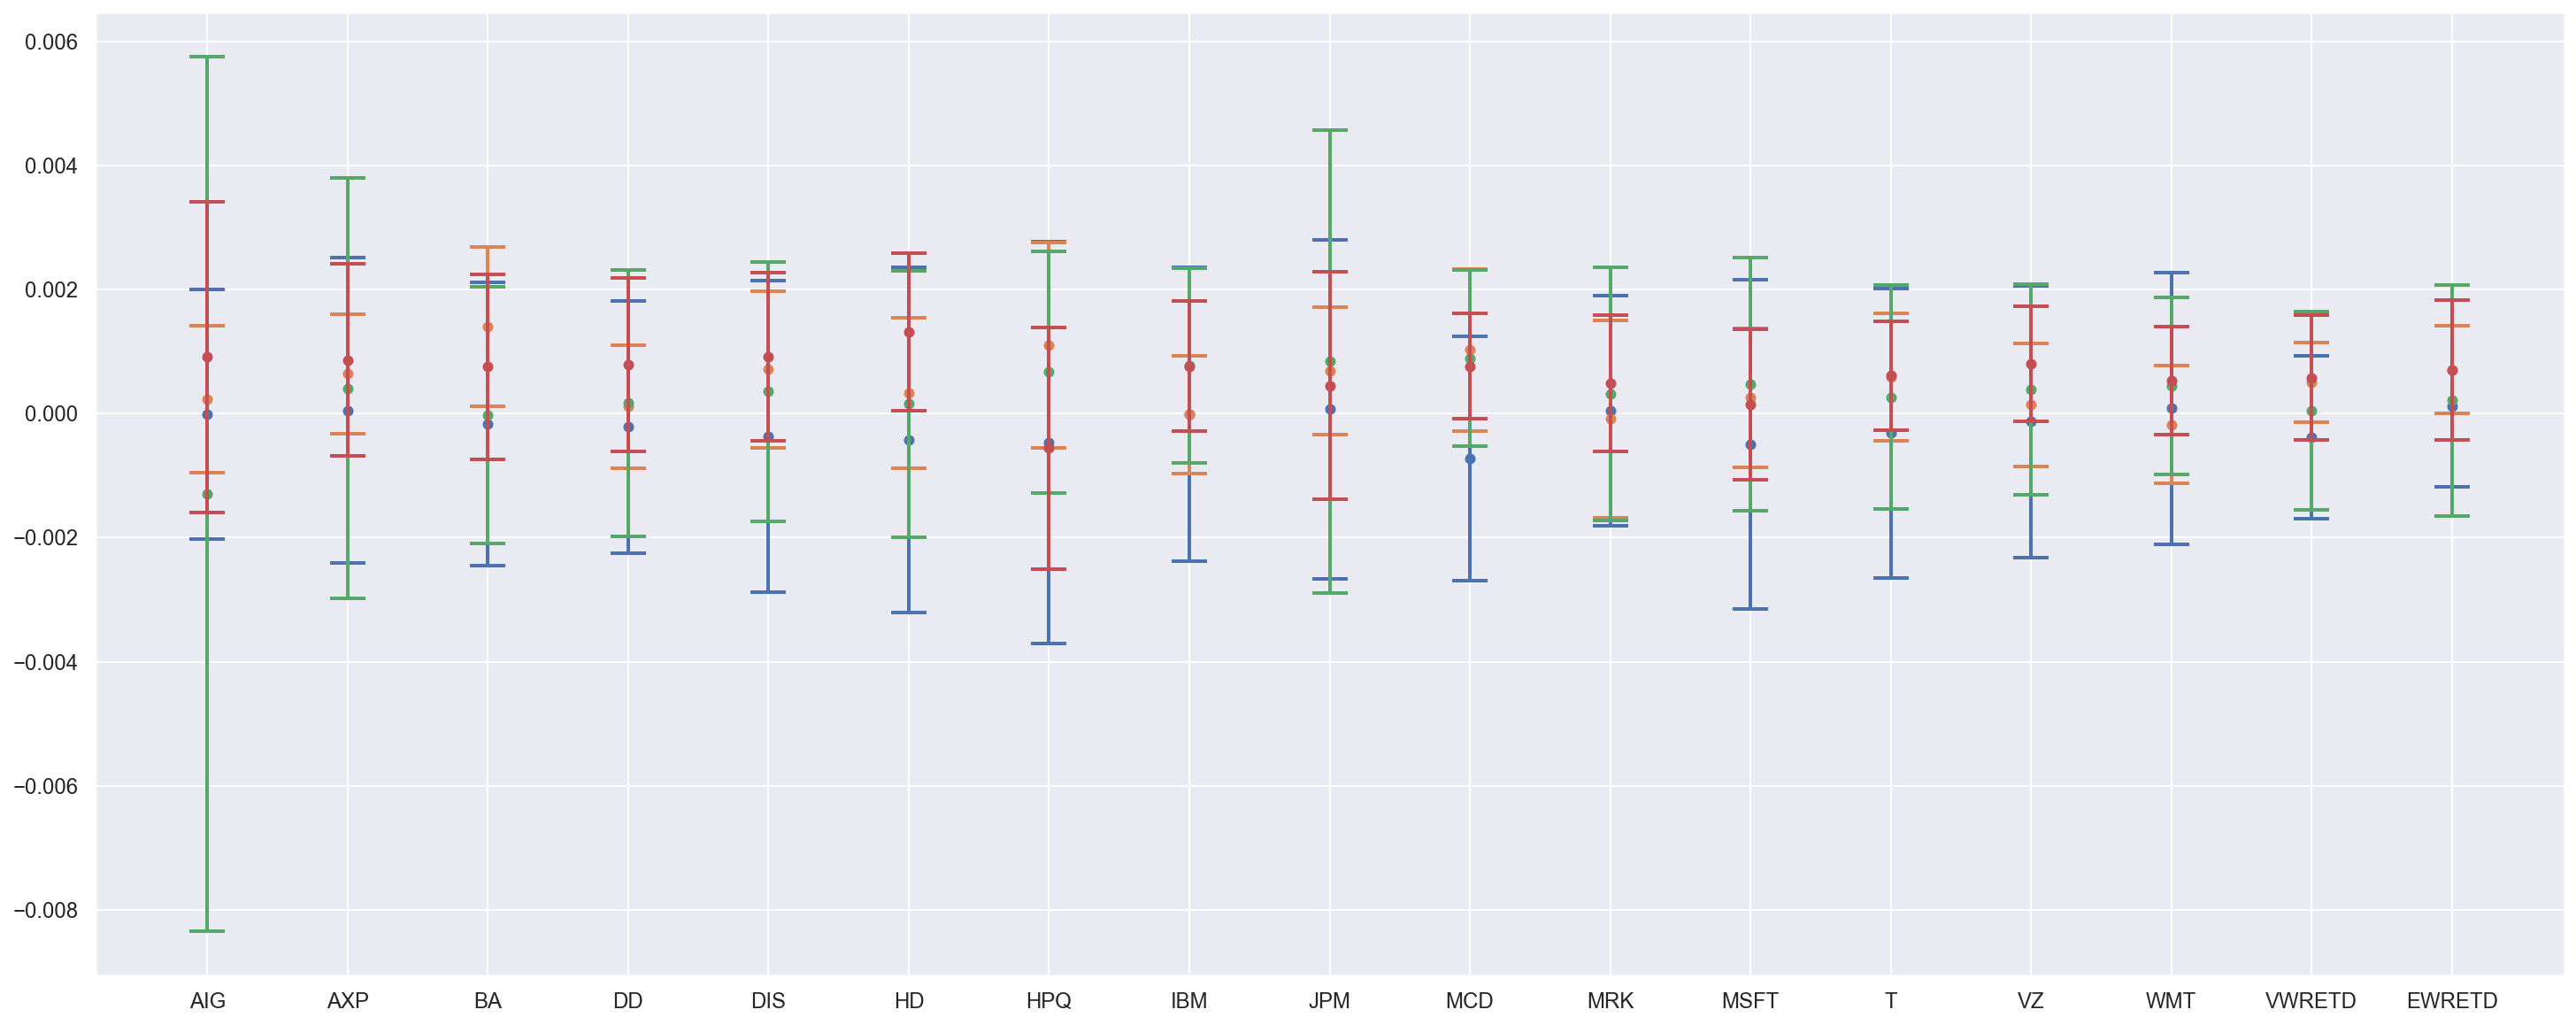

In [92]:
fig,ax = plt.subplots(figsize=(25,10))
for i in range(17):
    colors = sns.color_palette(n_colors= 4)
    for j in range(4):
        entry = conf_interval_subgroup.iloc[j*17+i]
        plt.plot( (i,i),(entry.lower_bound,entry.upper_bound),marker='_',color=cm.colors.to_rgba(colors[j]),linewidth=2.0,markersize=20.0,markeredgewidth=2.0)
        plt.plot(i,entry['mean'],marker='.',c=cm.colors.to_rgba(colors[j]),markersize=10.0)
plt.xticks(ticks=range(17),labels=conf_interval.index)
plt.show();

Similarly to Part 1 we notice a lot more variation amongst stocks vs. indices and in particular AIG which has the widest confidence intervals and inter-period variations. Indexes are again a lot more stable and range bound.

#### Part 4

Calculate the kurtosis, skew and studentized range. Lets create a function to create the output we need

In [30]:
def calc_distributional_properties(x):
    kurtosis = x.kurtosis()
    skew = x.skew()
    sr = (x.max() - x.min())/x.std()
    cnt = len(x)
    return pd.Series({'skew':skew,'kurtosis':kurtosis,'studentized range':sr, 'count':cnt})

#Note: be careful, the 'kurtosis' method returns the Fisher kurtosis, which is the Pearson kurtosis subtracted by 3

In [31]:
stats_df = daily_df.apply(calc_distributional_properties)
stats_df.T

skew   kurtosis  studentized range   count
AIG     1.443548  57.768993          28.950643  3323.0
AXP     0.391390   8.661732          15.015326  3323.0
BA     -0.037447   4.797938          16.202366  3323.0
DD      0.015732   4.757748          11.953218  3323.0
DIS     0.163916   7.508041          16.373105  3323.0
HD     -0.371223  12.610210          19.482097  3323.0
HPQ     0.028067   6.786254          14.646620  3323.0
IBM     0.258555   7.705462          16.140250  3323.0
JPM     0.819962  12.103479          16.154286  3323.0
MCD    -0.023150   5.304005          13.784602  3323.0
MRK    -0.918463  18.722477          21.173888  3323.0
MSFT    0.267363   9.378528          16.873175  3323.0
T       0.341974   6.473443          15.968391  3323.0
VZ      0.361231   6.596448          15.359483  3323.0
WMT     0.347028   5.354625          12.234135  3323.0
VWRETD  0.034832   7.540327          15.361692  3323.0
EWRETD  0.008538   7.869645          15.071036  3323.0

Testing for normality: The Jarque-Bera test uses the skewness and kurtosis of the sample data to see if it matches a normal distribution.
For large sample sizes, the test statistic has a chi-square distribution with two degrees of freedom, for which the critical value at 95% is 5.991

In [32]:
#Define the Jarque-Bera function based on Fisher's Kurtosis
def JB(df):
    return (df['count']/6) * (df['skew']**2 + 0.25*(df['kurtosis'])**2)

In [33]:
stats_df2 = stats_df.T
stats_df2['JB_test'] = stats_df2.apply(lambda x: JB(x), axis=1)
stats_df2

skew   kurtosis  studentized range   count        JB_test
AIG     1.443548  57.768993          28.950643  3323.0  463225.069441
AXP     0.391390   8.661732          15.015326  3323.0   10472.759736
BA     -0.037447   4.797938          16.202366  3323.0    3188.116624
DD      0.015732   4.757748          11.953218  3323.0    3134.302461
DIS     0.163916   7.508041          16.373105  3323.0    7819.871396
HD     -0.371223  12.610210          19.482097  3323.0   22093.605803
HPQ     0.028067   6.786254          14.646620  3323.0    6376.891900
IBM     0.258555   7.705462          16.140250  3323.0    8257.870307
JPM     0.819962  12.103479          16.154286  3323.0   20655.705255
MCD    -0.023150   5.304005          13.784602  3323.0    3895.470878
MRK    -0.918463  18.722477          21.173888  3323.0   49001.158007
MSFT    0.267363   9.378528          16.873175  3323.0   12217.940896
T       0.341974   6.473443          15.968391  3323.0    5866.929348
VZ      0.361231   6.596448          15.359483  3323.0    6097.024224
WMT     0.347028   5.354625          12.234135  3323.0    4036.575847
VWRETD  0.034832   7.540327          15.361692  3323.0    7872.933458
EWRETD  0.008538   7.869645          15.071036  3323.0    8574.947630

The Jarque-Bera test rejects all distributions for normality

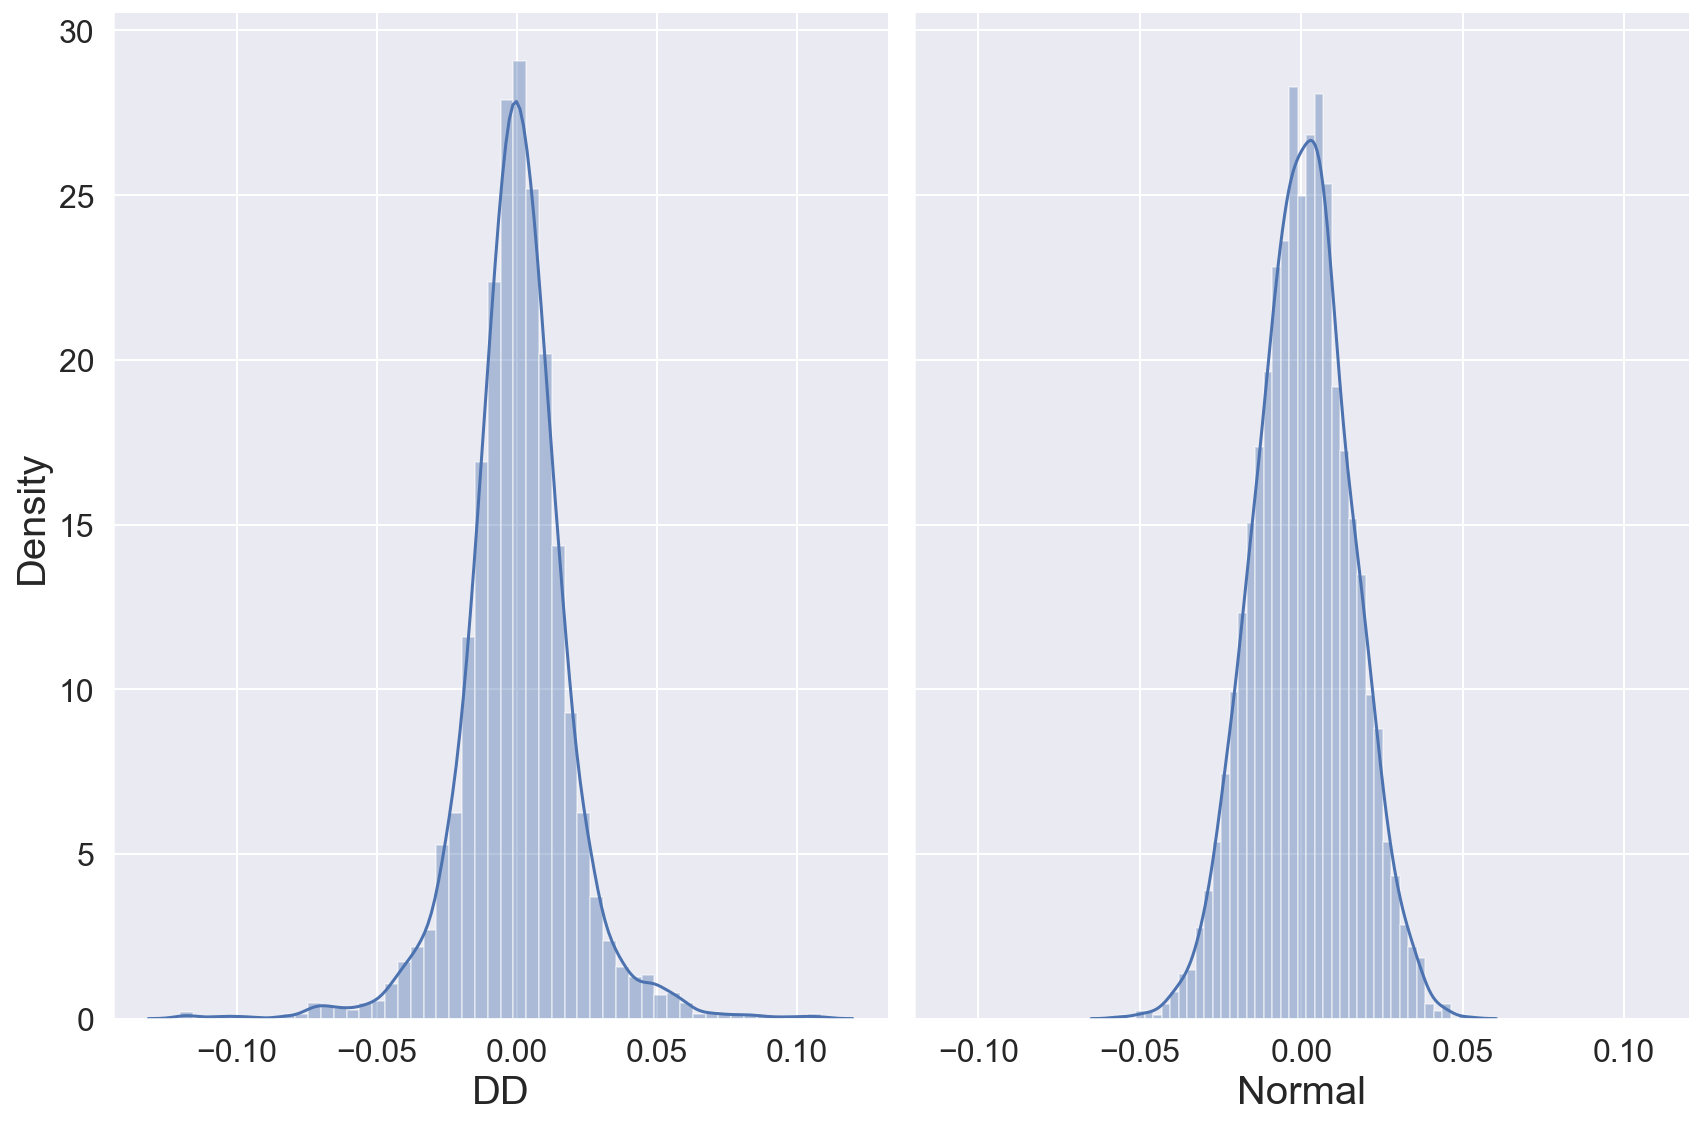

In [34]:
#Let's look at log returns too as a comparison
d_15stock_log = d_15stock.RET.apply(lambda x: np.log1p(x))
daily_logdf = d_15stock_log.unstack(level=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(daily_logdf.DD,ax=ax1)
_ = sns.distplot(idx_2,ax=ax2)
_ = plt.ylabel('Density')
_ = plt.xlim(-0.12, 0.12)
sns.despine()
plt.tight_layout()
plt.show()

_Note:_ When taking the log of the returns, the visual inspection of the distribution gets closer to Normal, but still with excess kurtosis

In [35]:
subgrp_stats_df = daily_df.stack().groupby(level=[1,2]).apply(calc_distributional_properties).unstack(level=2)

Let's do all the stats at the same time this time to save some typing

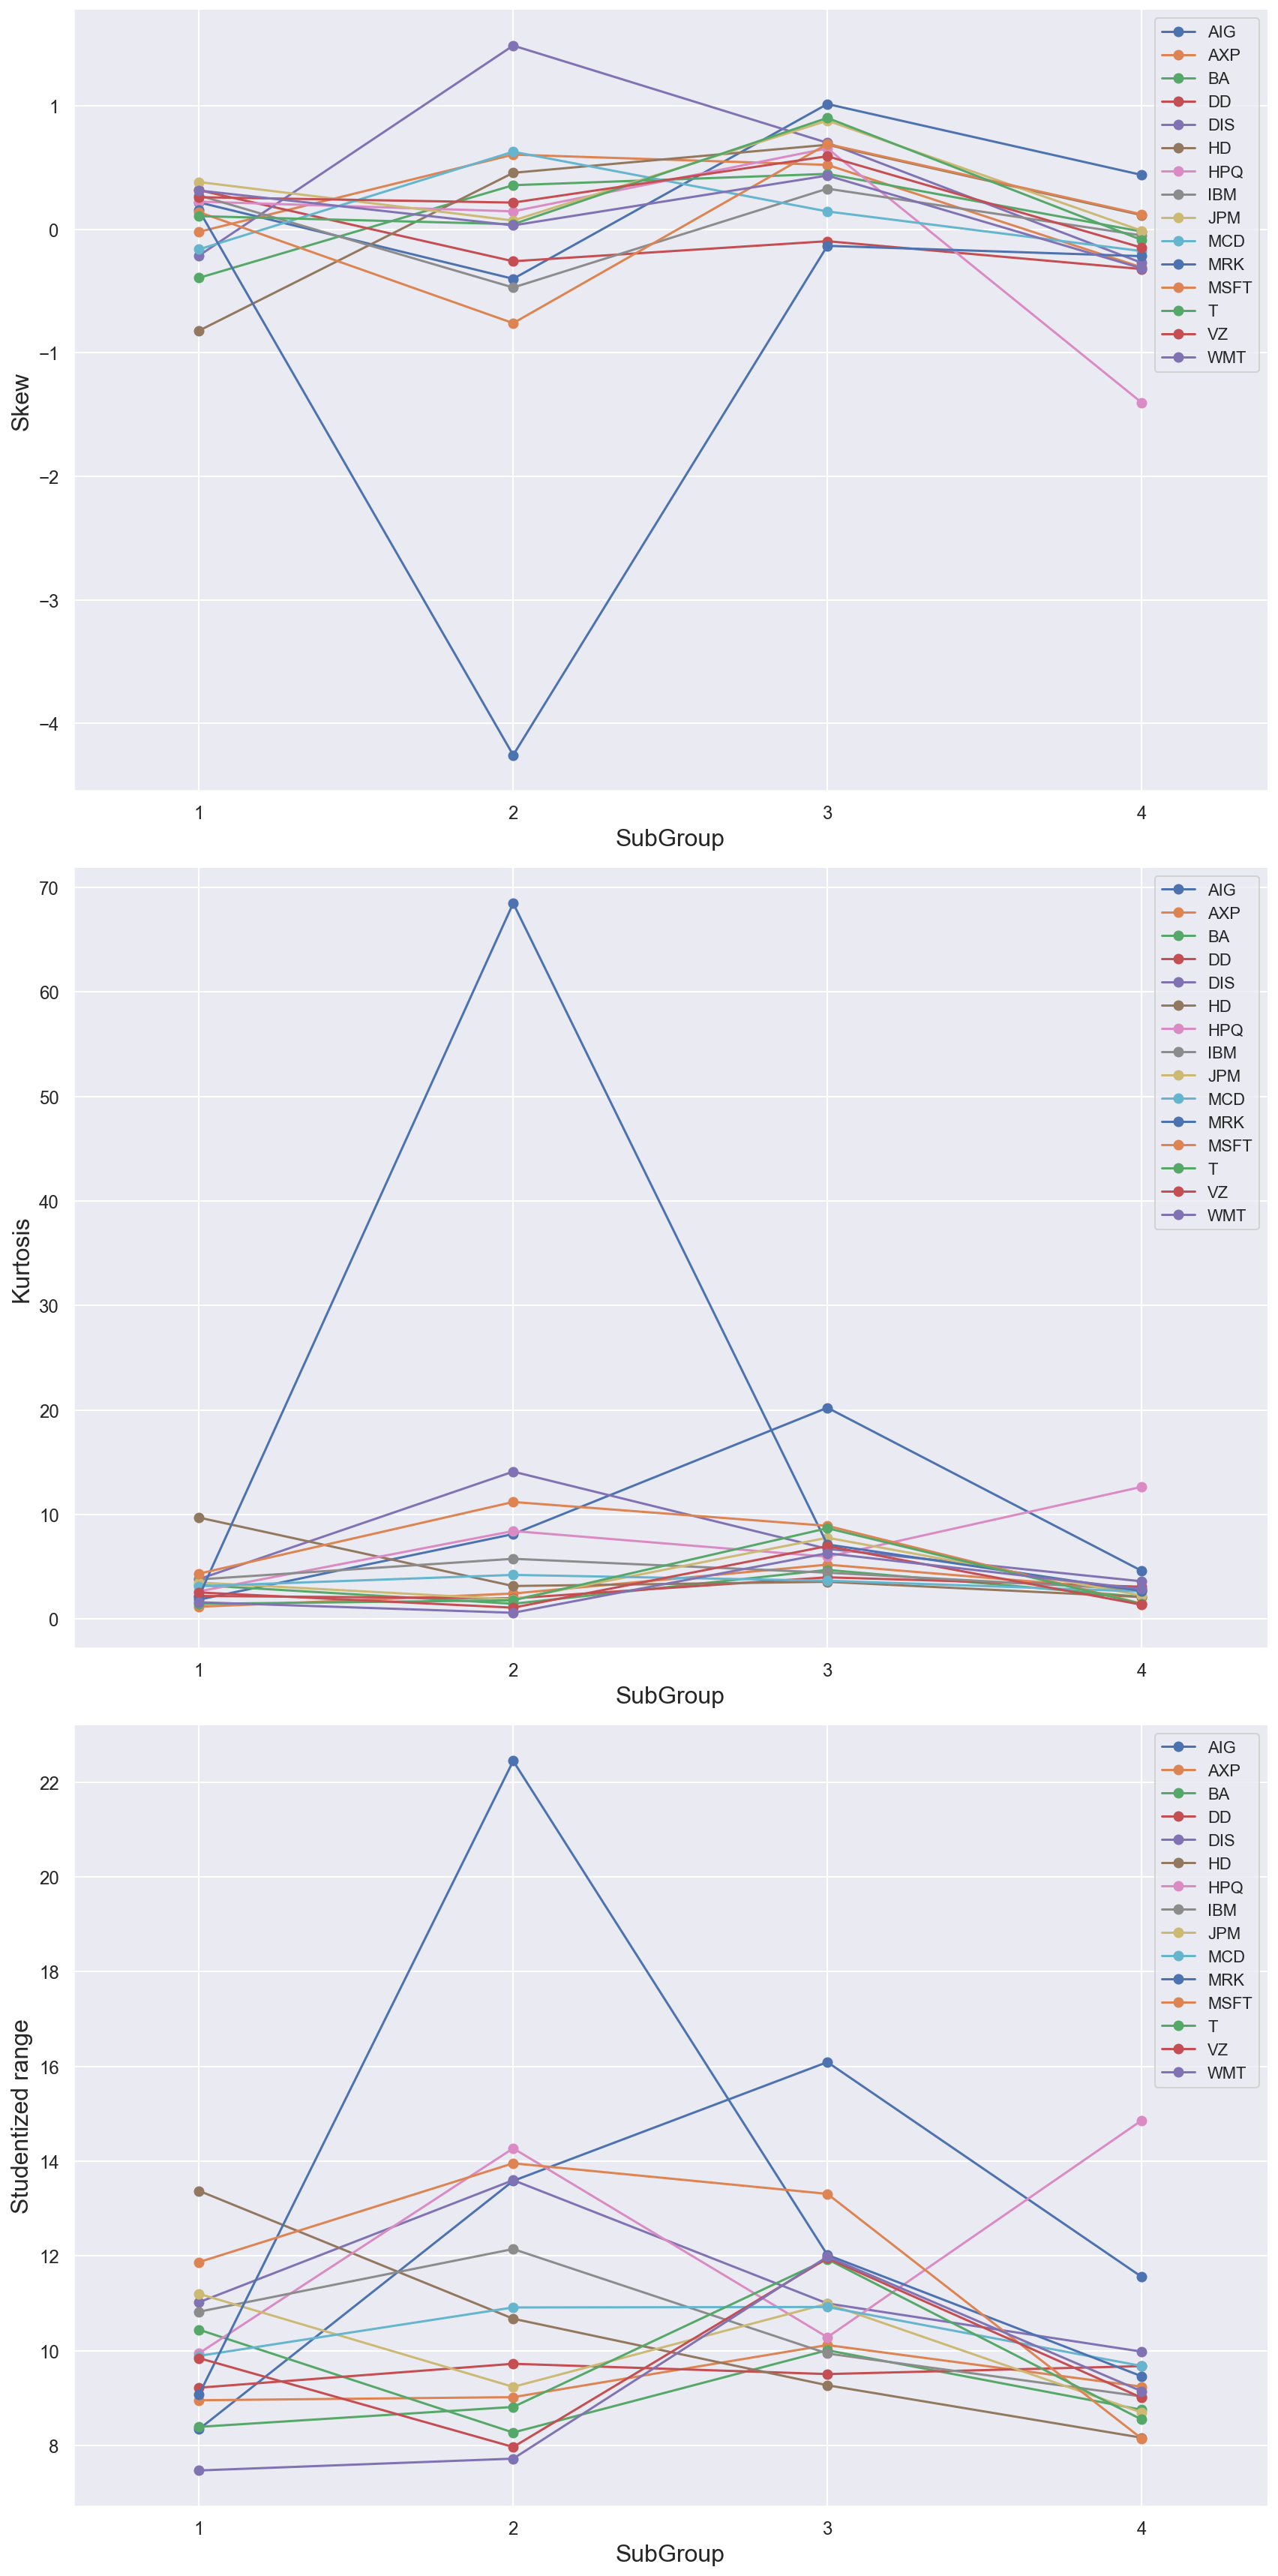

In [93]:
fig,ax = plt.subplots(3,1,figsize=(12,8*3))
for i, stat in enumerate(['skew','kurtosis','studentized range']):
    subgrp_stats_df.loc[pd.IndexSlice[:,stock_cols],stat].unstack(level=1).plot(ax = ax[i],marker='o')
    _ = ax[i].set_xlabel('SubGroup')
    _ = ax[i].set_ylabel(stat.capitalize())
    _ = ax[i].legend()
    _ = ax[i].axes.set_xticklabels(labels = [str(i) for i in range(1,5) ])
    _ = ax[i].set_xticks(range(1,5))
    _ = ax[i].set_xlim(0.6,4.4)
sns.despine()
plt.tight_layout()
plt.show();

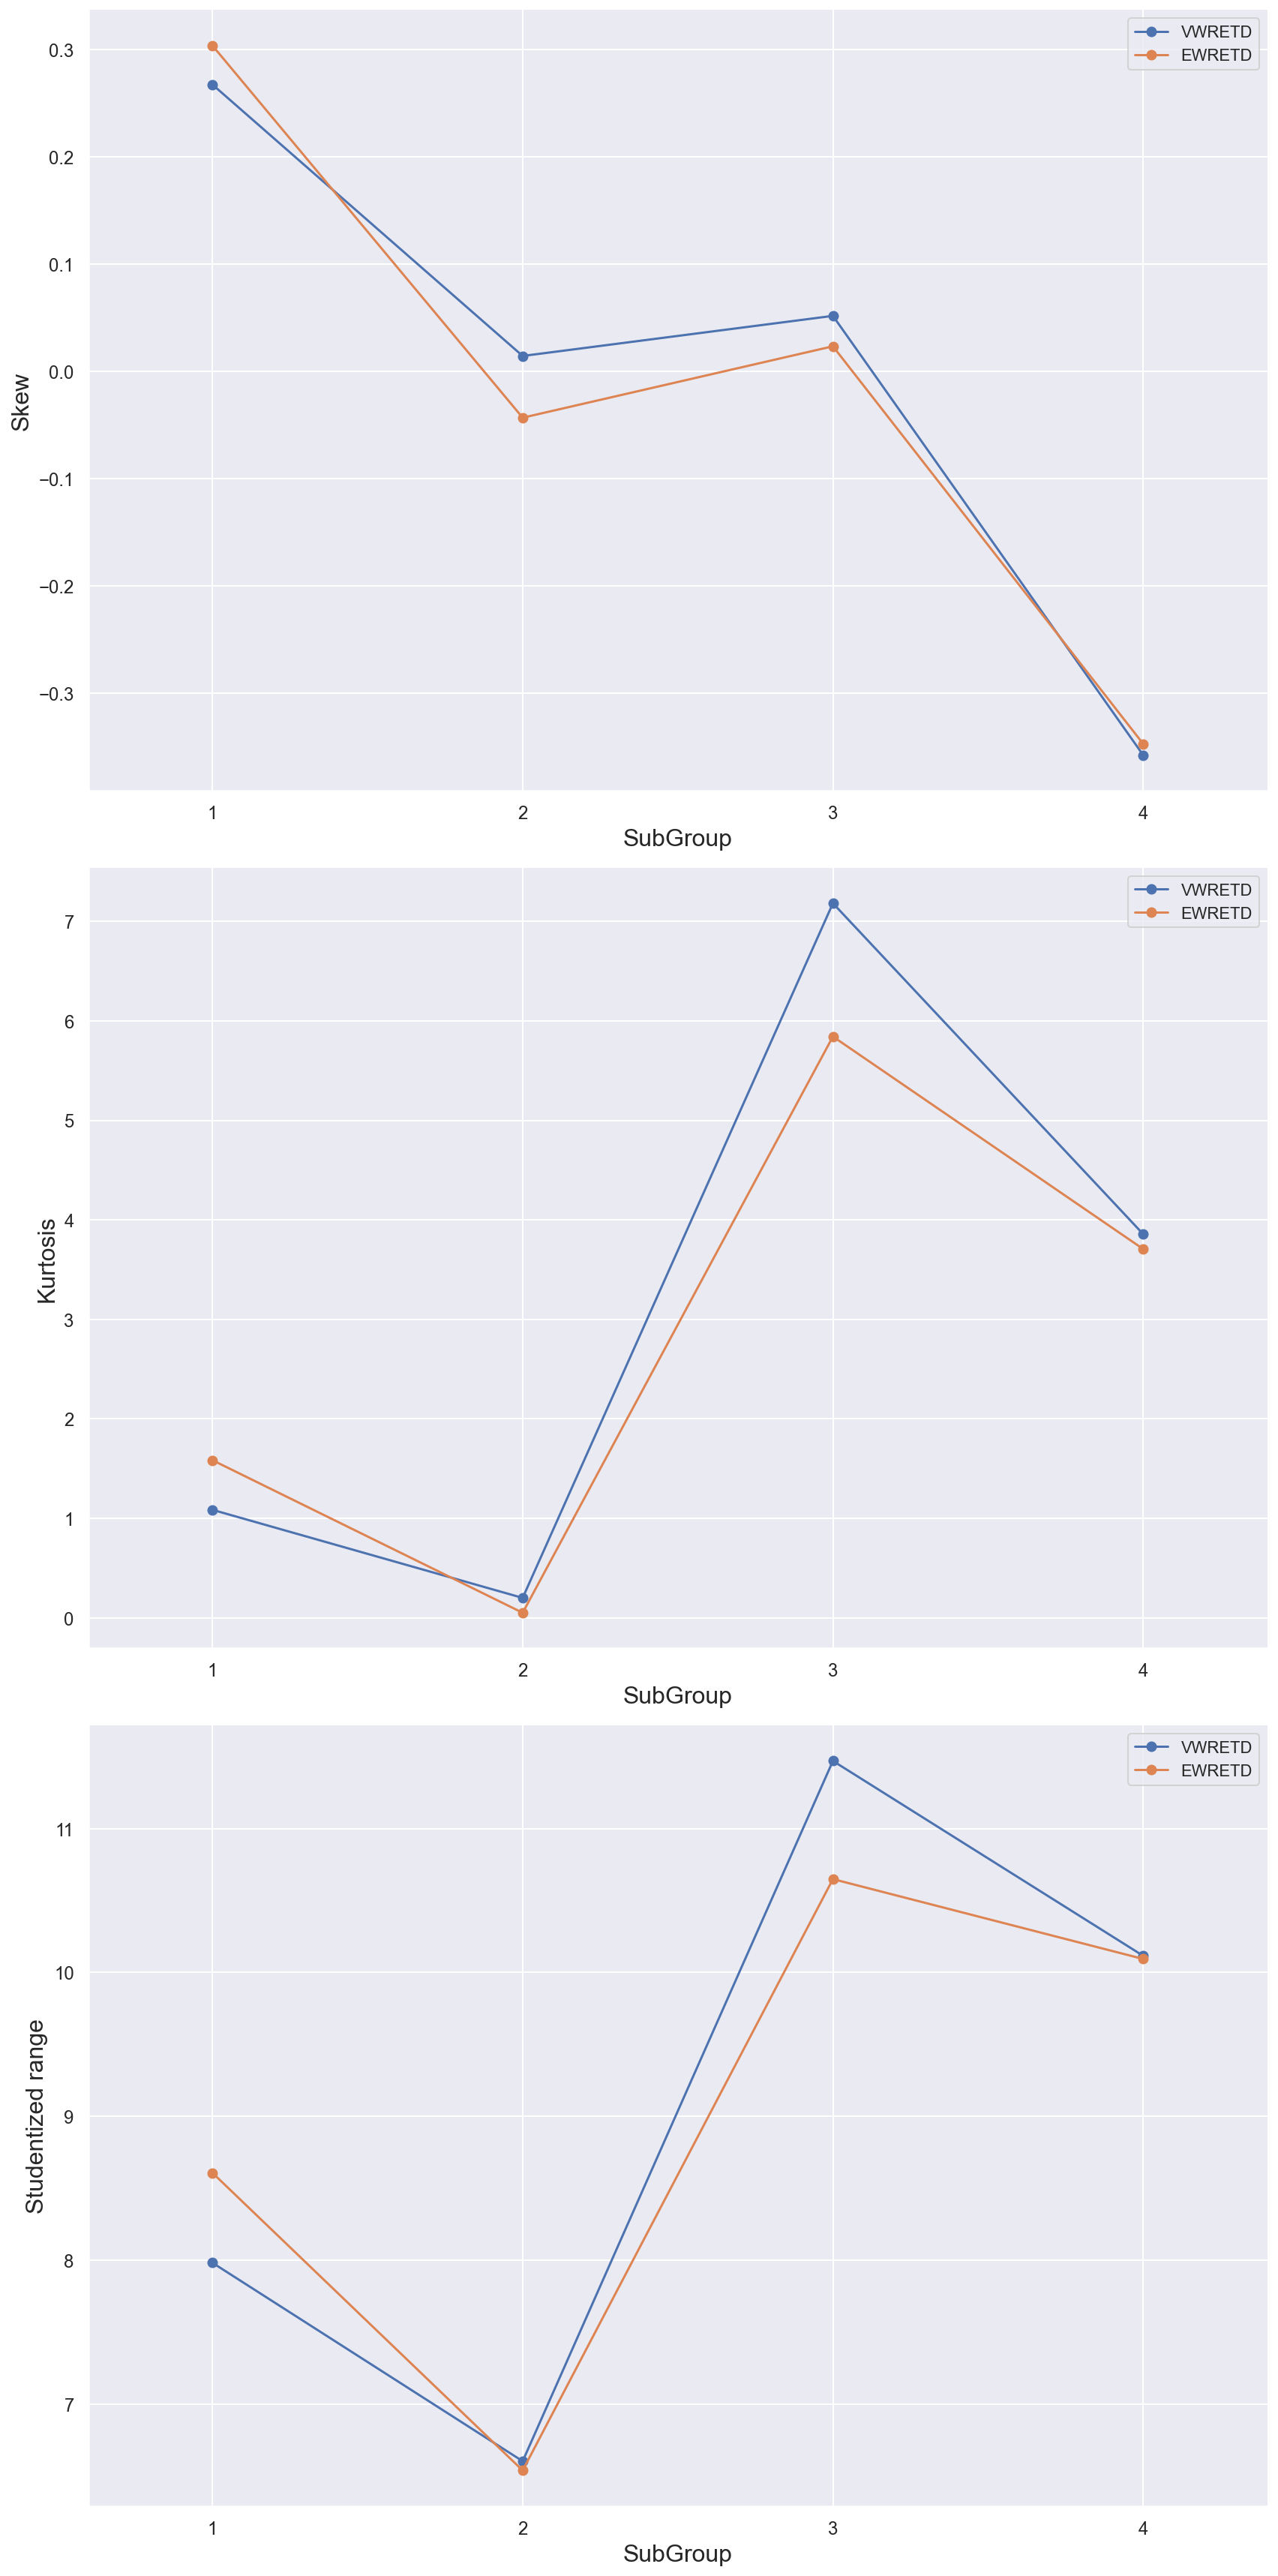

In [94]:
fig,ax = plt.subplots(3,1,figsize=(12,8*3))
for i, stat in enumerate(['skew','kurtosis','studentized range']):
    subgrp_stats_df.loc[pd.IndexSlice[:,idx_cols],stat].unstack(level=1).plot(ax = ax[i],marker='o')
    _ = ax[i].set_xlabel('SubGroup')
    _ = ax[i].set_ylabel(stat.capitalize())
    _ = ax[i].legend()
    _ = ax[i].axes.set_xticklabels(labels = [str(i) for i in range(1,5) ])
    _ = ax[i].set_xticks(range(1,5))
    _ = ax[i].set_xlim(0.6,4.4)
sns.despine()
plt.tight_layout();

Let's look at monthly returns as a comparison

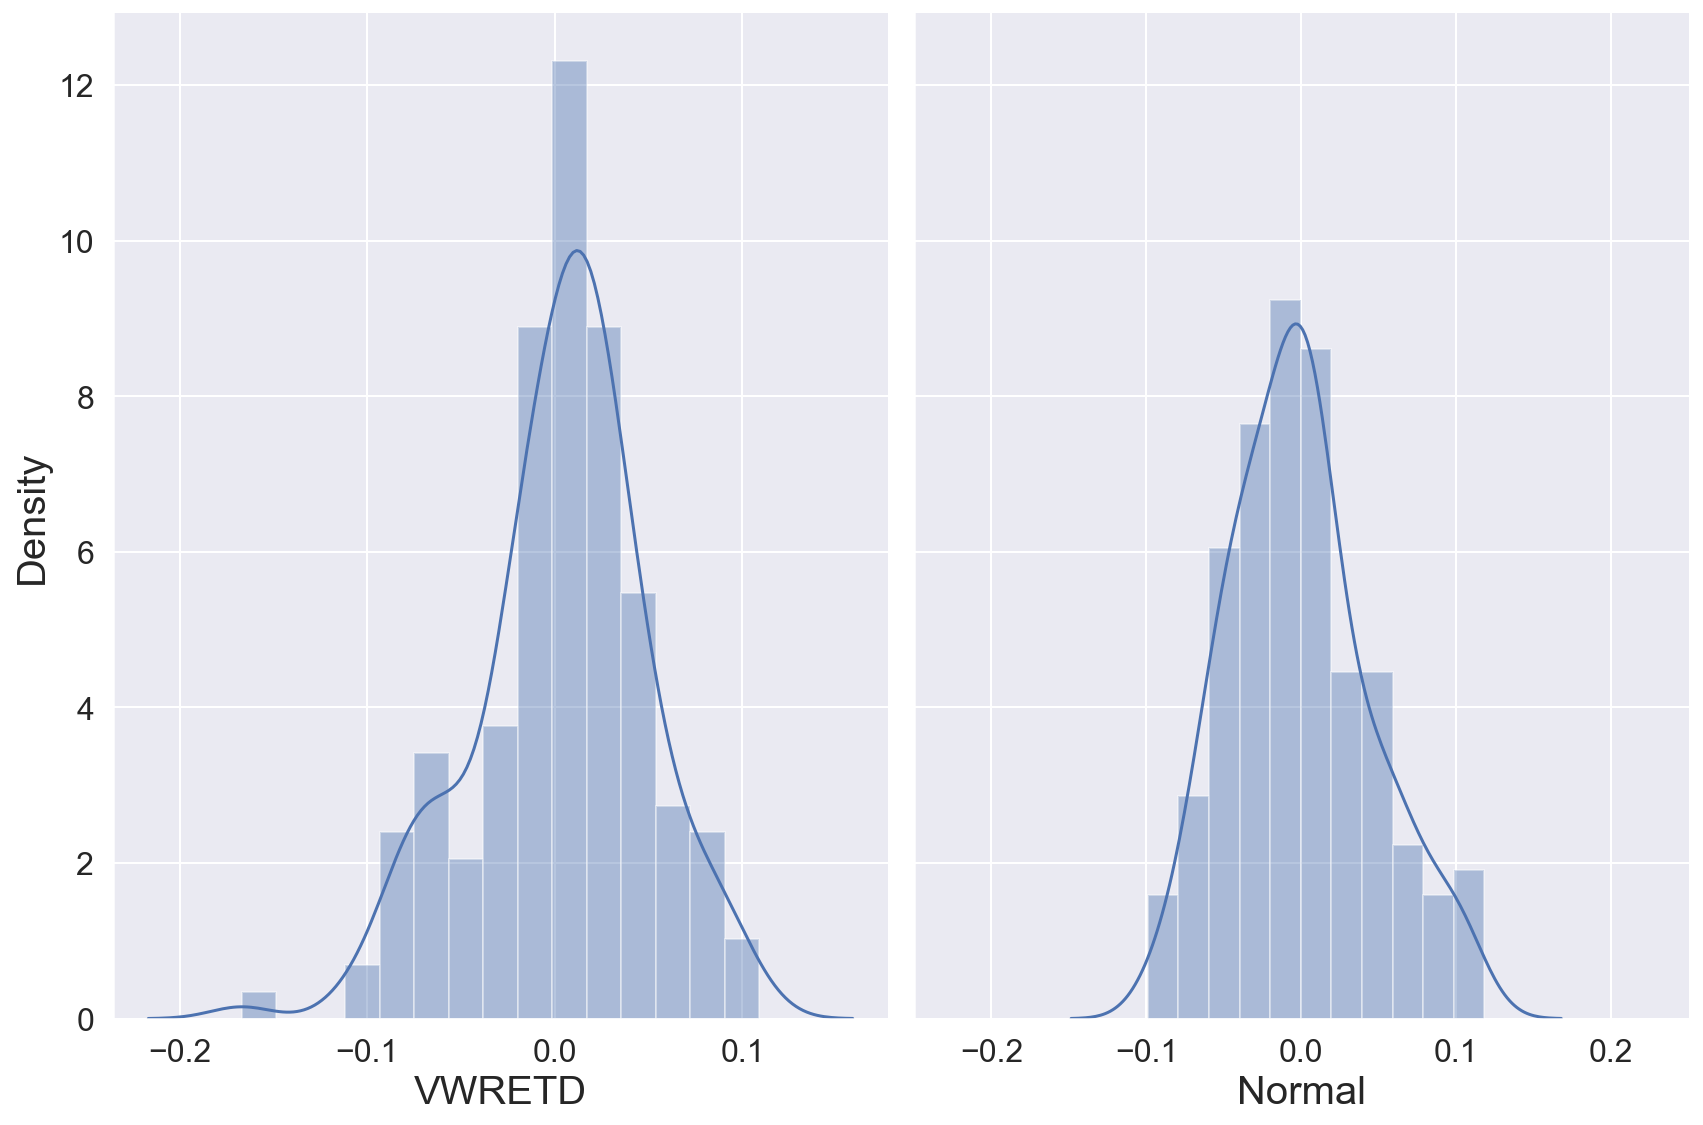

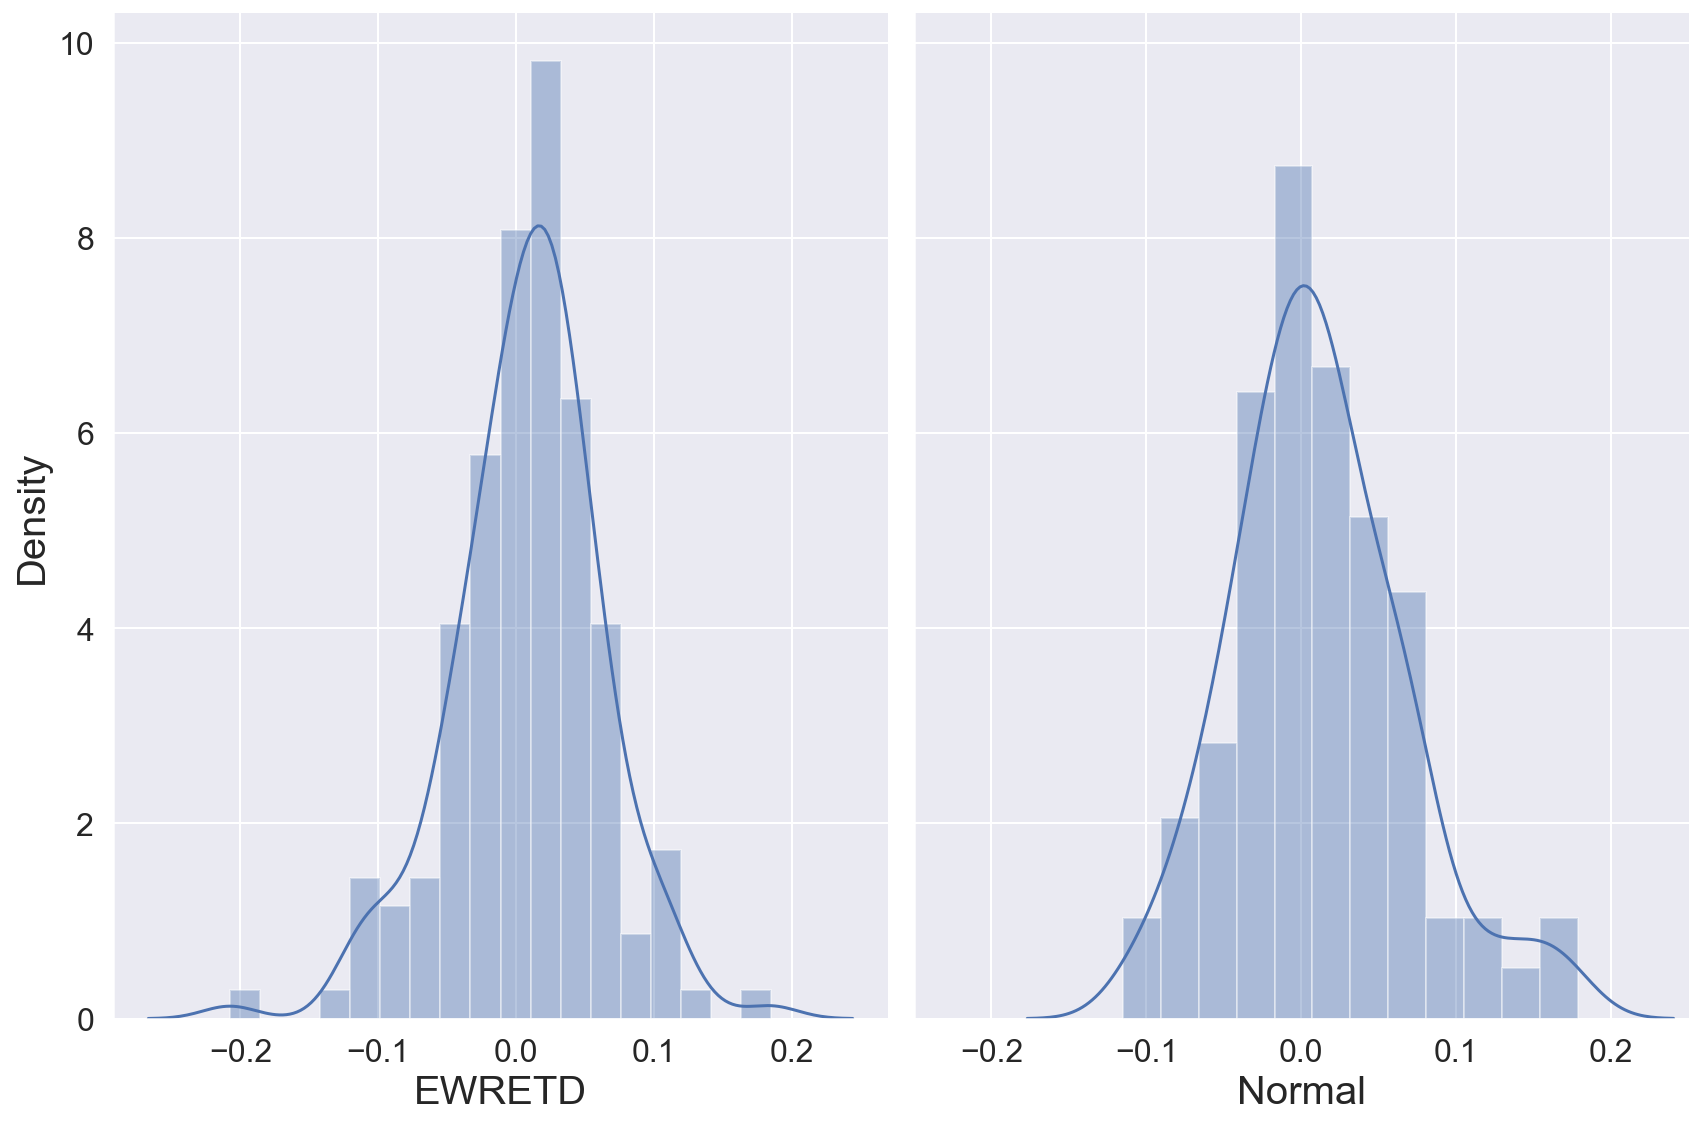

In [38]:
#Visual inspection
means = m_indexes.mean(axis=0)
stds = m_indexes.std(axis=0)
n_points = m_indexes.shape[0]
idx_1 = pd.Series(np.random.normal(means[0],stds[0],n_points),name='Normal')
idx_2 = pd.Series(np.random.normal(means[1],stds[1],n_points),name='Normal')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(m_indexes.VWRETD, ax=ax1)
_ = sns.distplot(idx_1, ax=ax2)
_ = plt.ylabel('Density')
_ = plt.xlim(-0.25, 0.25)
sns.despine()
plt.tight_layout()
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(m_indexes.EWRETD, ax=ax1)
_ = sns.distplot(idx_2, ax=ax2)
_ = plt.ylabel('Density')
_ = plt.xlim(-0.25, 0.25)
sns.despine()
plt.tight_layout()
plt.show()

In [39]:
#Let's compute the distributional properties of the monthly series as well:
monthly_df = m_15stock.RET.unstack(level=0).join(m_indexes)
m_stats_df = monthly_df.apply(calc_distributional_properties)
m_stats_df.T

skew   kurtosis  studentized range  count
AIG     5.552751  50.167980          12.378241  159.0
AXP     3.218726  28.181150          10.946548  159.0
BA     -0.712217   1.311814           6.114679  159.0
DD      0.124346   0.872481           6.001017  159.0
DIS    -0.205827   1.454345           6.603567  159.0
HD     -0.134095  -0.055522           5.305010  159.0
HPQ     0.135526   1.264266           6.312885  159.0
IBM     0.600115   4.053303           7.522995  159.0
JPM    -0.150452   0.709296           5.452512  159.0
MCD    -0.549056   2.075101           7.017098  159.0
MRK    -0.180276   0.847960           5.974666  159.0
MSFT    0.407882   3.194714           8.072419  159.0
T       0.162484   1.623681           6.686135  159.0
VZ      0.965881   5.135458           8.292804  159.0
WMT    -0.285115   1.208841           6.349503  159.0
VWRETD -0.490798   0.754885           6.037195  159.0
EWRETD -0.384178   1.618244           7.218017  159.0

In [40]:
#To test for normality, we will repeat the Jarque-Bera test we had performed on the daily series:
m_stats_df2 = m_stats_df.T
m_stats_df2['JB_test'] = m_stats_df2.apply(lambda x: JB(x), axis=1)
m_stats_df2

skew   kurtosis  studentized range  count       JB_test
AIG     5.552751  50.167980          12.378241  159.0  17491.049590
AXP     3.218726  28.181150          10.946548  159.0   5535.969388
BA     -0.712217   1.311814           6.114679  159.0     24.842880
DD      0.124346   0.872481           6.001017  159.0      5.452844
DIS    -0.205827   1.454345           6.603567  159.0     15.135341
HD     -0.134095  -0.055522           5.305010  159.0      0.496931
HPQ     0.135526   1.264266           6.312885  159.0     11.075919
IBM     0.600115   4.053303           7.522995  159.0    118.387535
JPM    -0.150452   0.709296           5.452512  159.0      3.932897
MCD    -0.549056   2.075101           7.017098  159.0     36.516284
MRK    -0.180276   0.847960           5.974666  159.0      5.624847
MSFT    0.407882   3.194714           8.072419  159.0     72.024827
T       0.162484   1.623681           6.686135  159.0     18.165375
VZ      0.965881   5.135458           8.292804  159.0    199.443227
WMT    -0.285115   1.208841           6.349503  159.0     11.835287
VWRETD -0.490798   0.754885           6.037195  159.0     10.158663
EWRETD -0.384178   1.618244           7.218017  159.0     21.260185

_Note:_ as expected, monthly returns are _closer_ to Normal. We cannot reject normality at the 5% confidence based on the Jarque-Bera test for DD, HD, JPM, and MRK.

### Exercise 2

For the data in Exercise 1, carry out the following:
1. Perform a PCA on the 15-stock returns. Using the eigenvalues of the $\hat{\Sigma}$ matrix, identify the number of factors.
2. Compute the covariance between the returns and the factors and comment.

#### Part 1

As an exercise we'll do the PCA process by hand and then we can use scikit-learn to verify that we have done it right.

1. We start by calculating the mean for each column and we center each column around 0

In [41]:
#daily_s_df = daily_df.loc[pd.IndexSlice[:,stock_cols]].reset_index(level=1,drop=True)
daily_s_df = daily_df.loc[pd.IndexSlice[:,stock_cols]].reset_index(level=0,drop=True)


In [42]:
C  = daily_s_df - daily_s_df.mean()

2. Next we calculate the covariance matrix of the returns

In [43]:
V = C.cov()

3. Finally we do the eigen decomposition

In [44]:
e_values,e_vectors = np.linalg.eig(V)

The eigenvalue represent how much variance is explained by each of the factors. In order to do dimentionality reduction we want to choose only the number of factors that explain most of the variance and throwing away the rest.

We do that by sorting and normailzing the eigenvalues. We plot the % of explained variance and we find the 'kink'  in the curve indicating that the additional factors explain less and less of the variance.

In [45]:
idx = np.argsort(e_values)[::-1] #Let's do argsort so we can then use it to chose the eigenvectors. argsort sorts ascending so we need to flip it
explained_variance = e_values[idx]/e_values.sum()

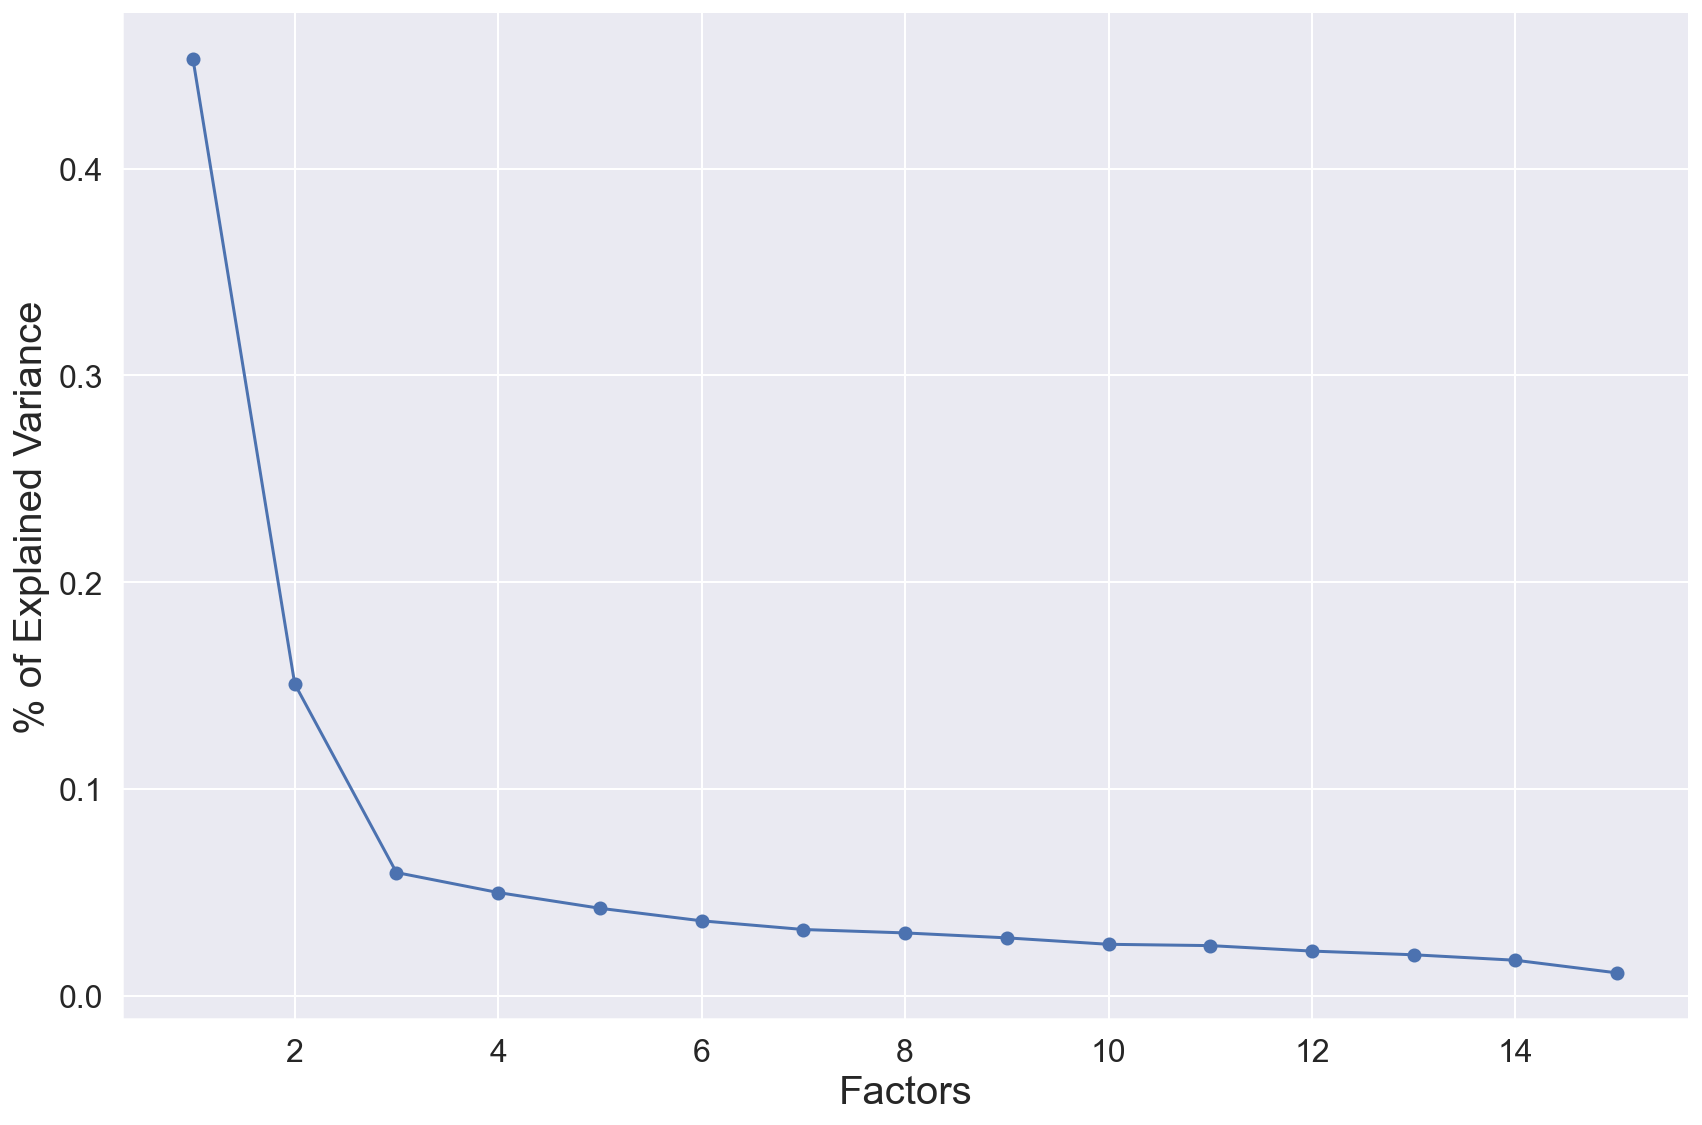

In [46]:
fig,ax = plt.subplots(figsize=(12,8))
_ = plt.plot(range(1,16),explained_variance,marker='o')
_ = plt.xlabel('Factors')
_ = plt.ylabel('% of Explained Variance')
sns.despine()
plt.tight_layout()
plt.show()

Based on our approach we should choose the first 3 factors. Let's look at how much of the variance is explained

In [47]:
print(f'Explained Variance: {np.round(explained_variance[:3].sum()*100,2)}%')


Explained Variance: 66.32%


The eigen vectors represent the **Factor Loadings** for each of the principal factors. We obtain the principal factor time series of returns calculated by doing a linear combination of the returns multiplied by the chosen eigen vectors

In [48]:
pca_factors = daily_s_df.dot(e_vectors[idx[0:3]].T)
pca_factors.shape

(3323, 3)

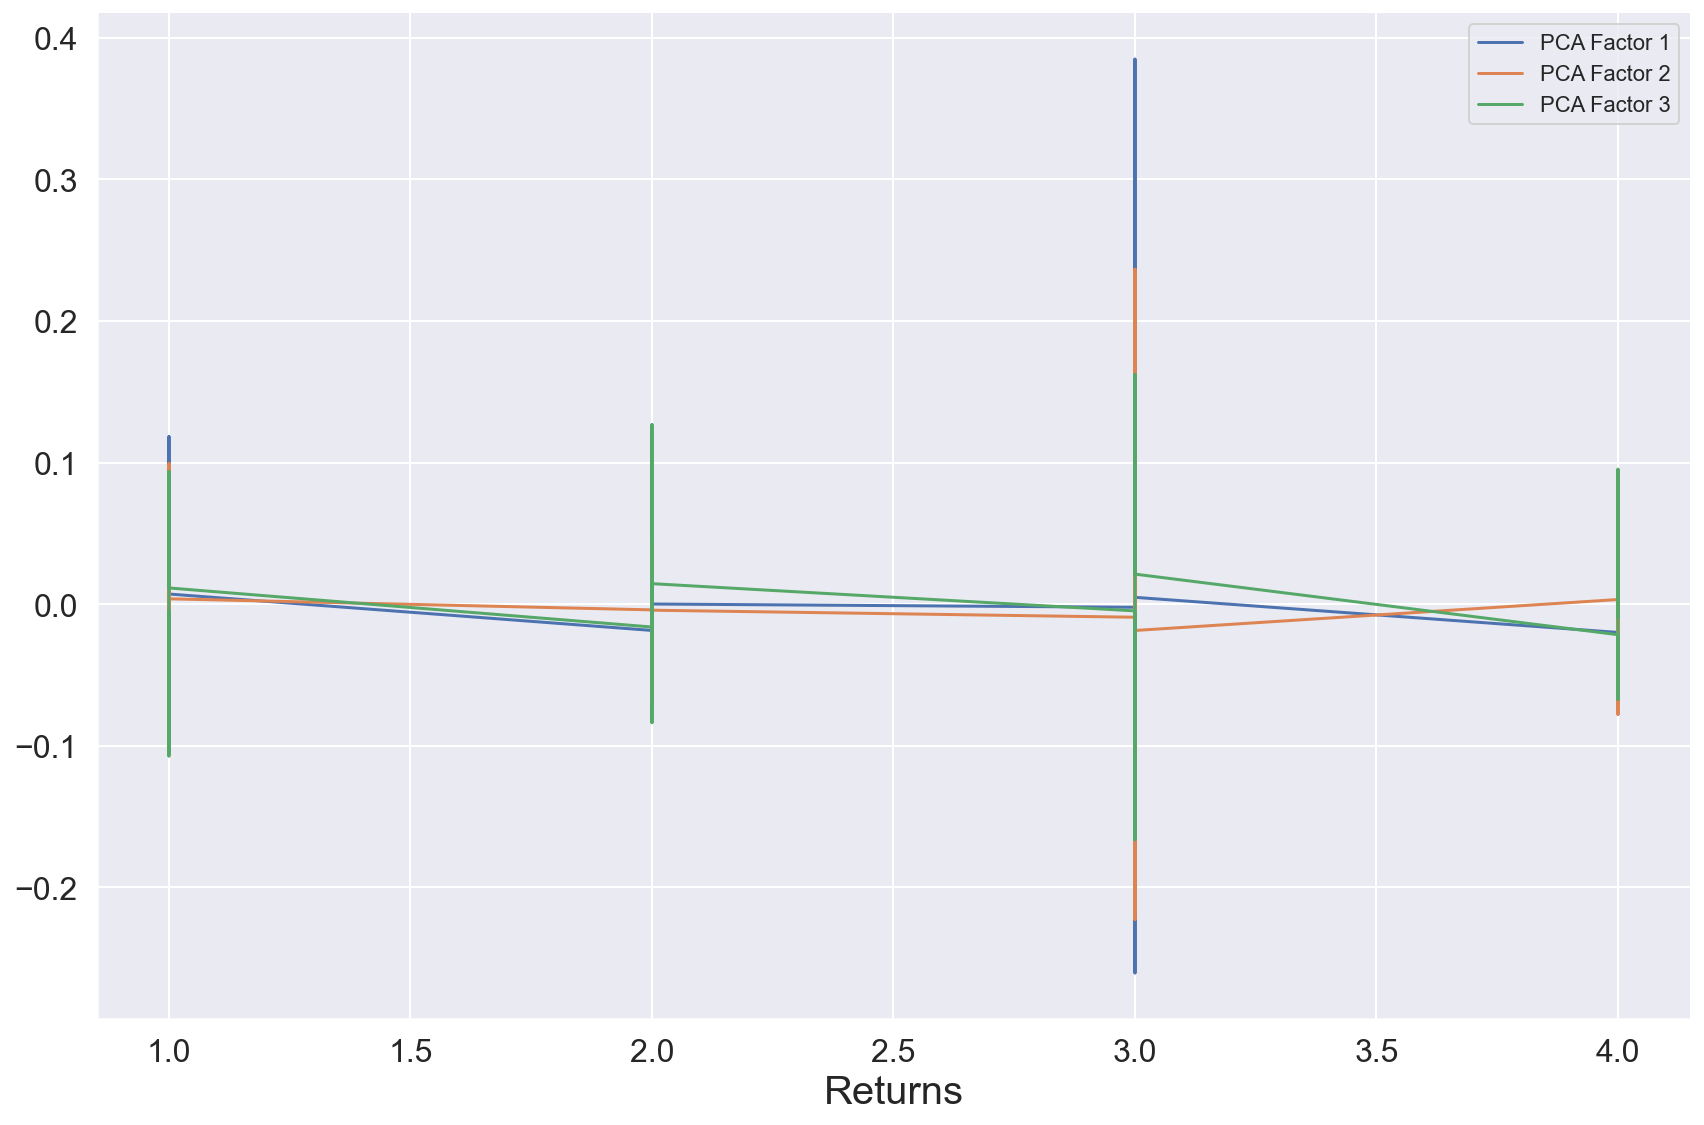

In [49]:
fig,ax = plt.subplots(figsize=(12,8))
_ = pca_factors.plot(ax=ax)
_ = plt.xlabel('Returns')
_ = plt.legend(['PCA Factor 1','PCA Factor 2','PCA Factor 3'])
sns.despine()
plt.tight_layout()
plt.show()

#### Part 2

In [50]:
np.sqrt(np.cov(C.values[:,0],pca_factors[0]))

array([[0.0437955 , 0.02451863],
       [0.02451863, 0.0243188 ]])

##### TODO Add Commentary


### Exercise 3

Consider the weekly exchange rate data used in Hu and Tsay (2014) [204] in file
_exchange_rates_2.csv_: British Pound (y<sub>1t</sub>), Norwegian Kroner (y<sub>2t</sub>), Swedish Kroner (y<sub>3t</sub>), Swiss Franc (y<sub>4t</sub>), Canadian Dollar (y<sub>5t</sub>), Singapore Dollar (y<sub>6t</sub>) and Australian Dollar (y<sub>7t</sub>) against US Dollar from March 22, 2000 to October 26, 2011.


(a) Test if the exchange rates are stationary individually via Dickey-Fuller test.

(b) Test for co-integration using the likelihood-ratio test given in (3.31). Assume that the order of the VAR model is, _p_ = 2.

(c) Compute the log returns: _r<sub>t</sub>_ = ln(Y<sub>t</sub>) - ln(Y<sub>t-1</sub>); Fit VAR(5) model for the returns and extract the residuals.

(d) Using the residuals from (c), compute the ${\Gamma}$<sub>k</sub> matrix in (3.48) for k = 5; 10; 20 and obtain the _M_-matrix in (3.49).

(e) Plot _MY<sub>t</sub>_ and comment on the linear combination that has low volatility.

(f) Check (a)–(e) for various regimes; note 2008–2009 is noted for its volatility.

In [51]:
d_curr = pd.read_csv('../datasets/exchange_rates_2.csv',index_col='DATE',parse_dates=['DATE'])
d_curr = d_curr.loc[:,['GBP','NOK','SEK','CHF','CAD','SGD','AUD']]
d_curr = d_curr[dt.datetime(2002, 1, 1, 0, 0) : dt.datetime(2011, 10, 26, 0, 0)]
d_curr = d_curr.drop([dt.datetime(2004, 10, 26, 0, 0)]) #data cleaning, missing one day
d_curr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2559 entries, 2002-01-01 to 2011-10-26
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GBP     2559 non-null   float64
 1   NOK     2559 non-null   float64
 2   SEK     2559 non-null   float64
 3   CHF     2559 non-null   float64
 4   CAD     2559 non-null   float64
 5   SGD     2559 non-null   float64
 6   AUD     2559 non-null   float64
dtypes: float64(7)
memory usage: 159.9 KB


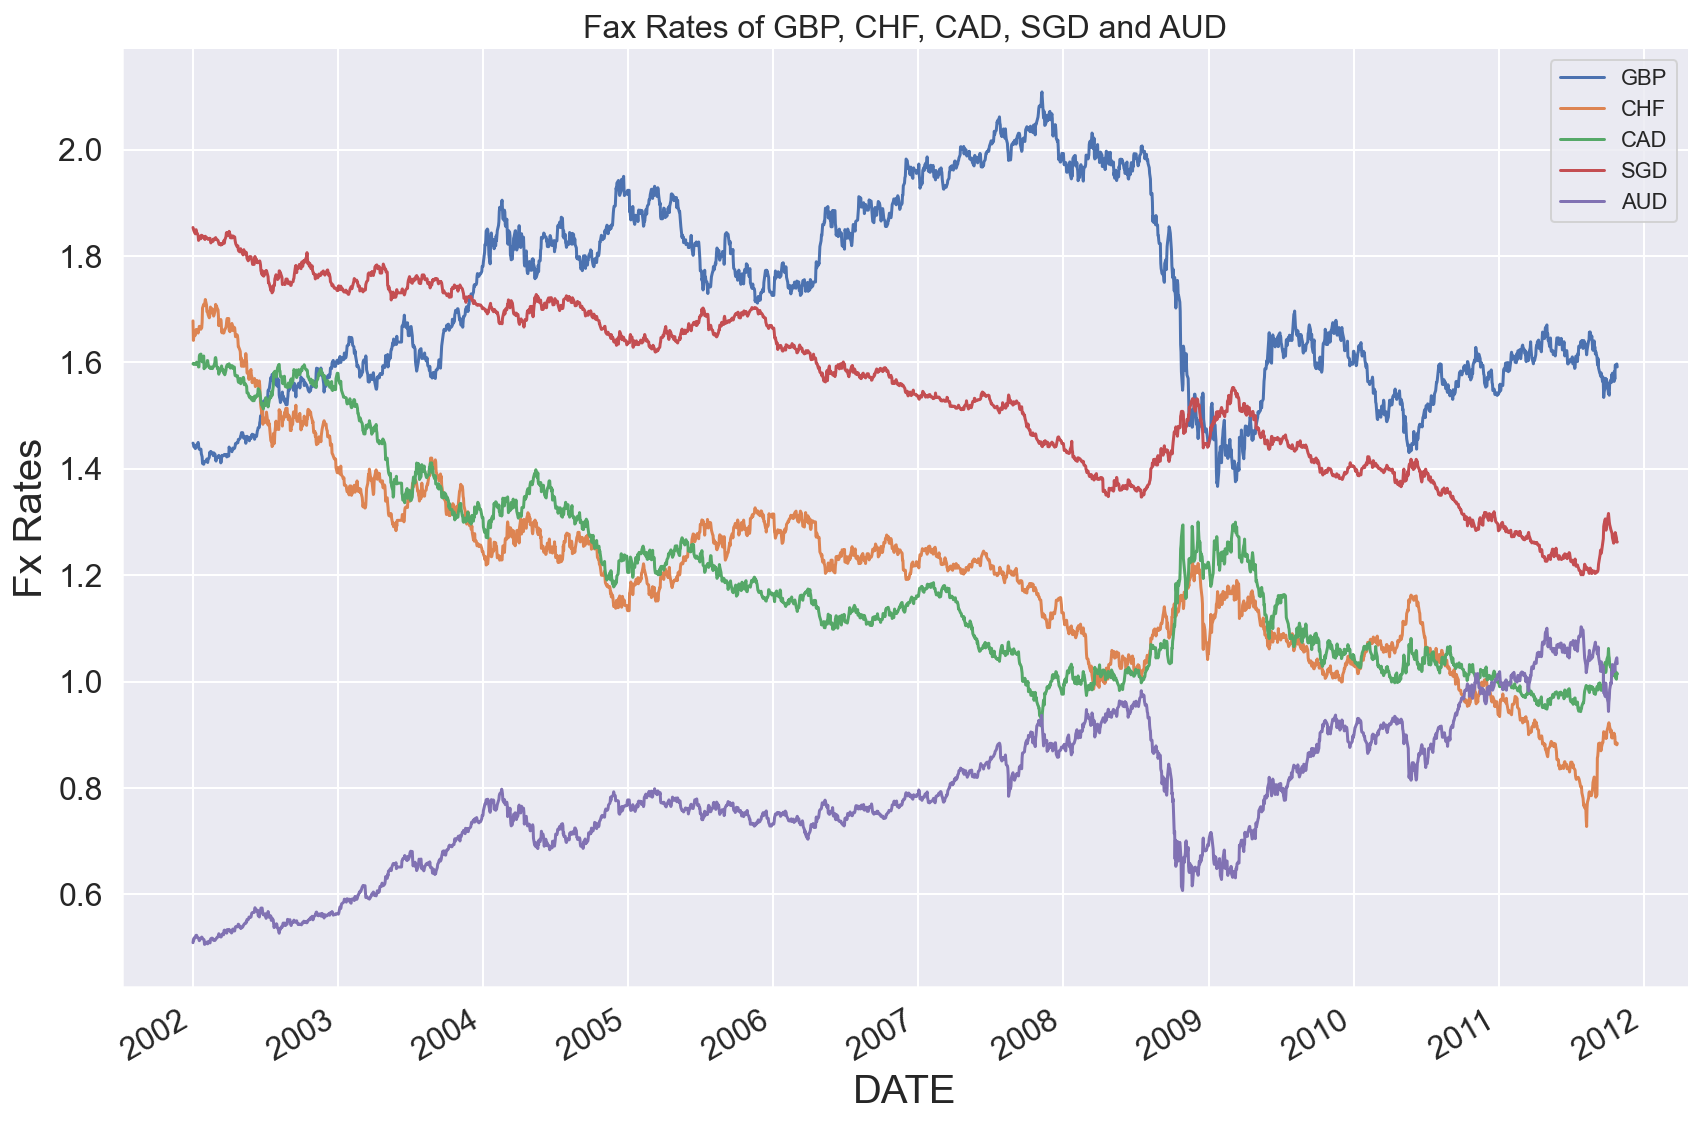

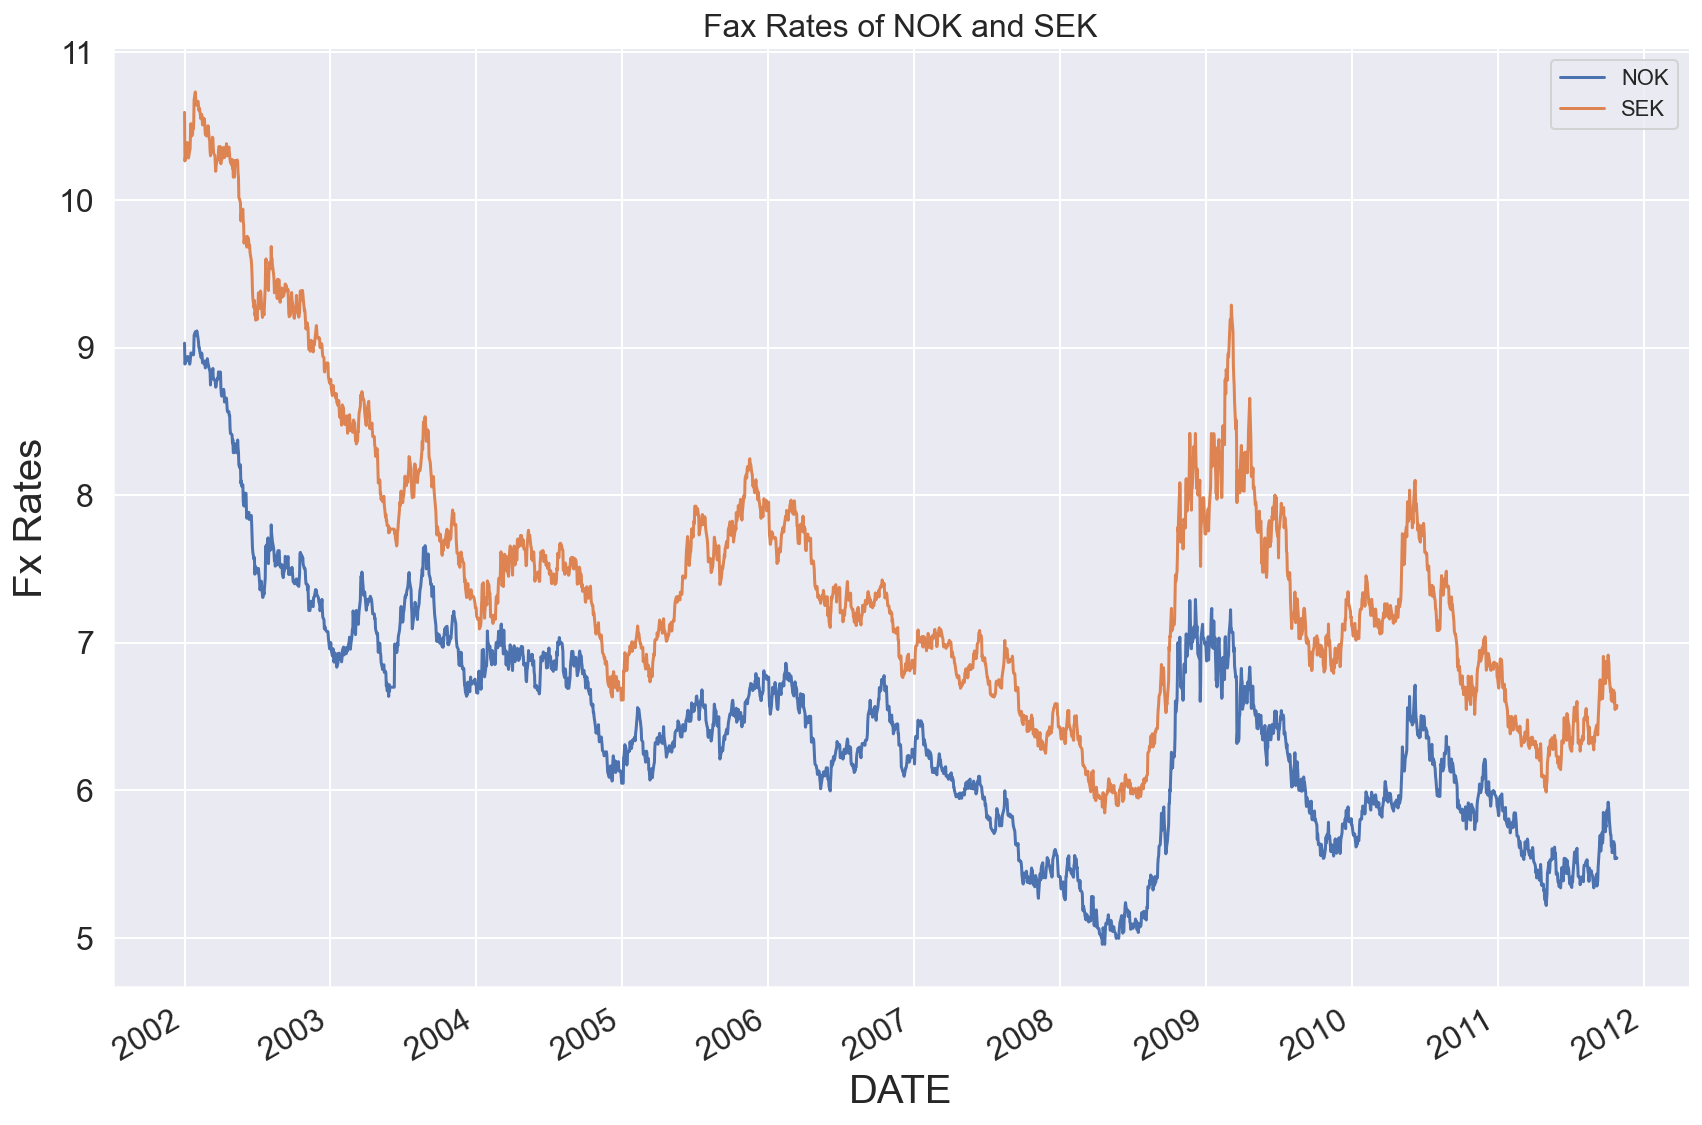

In [52]:
#Before running the ADF test, we need to inspect the time series to get a sense of the appropriate regression model

fig,ax = plt.subplots(figsize=(12,8))
_ = d_curr.loc[:,['GBP','CHF','CAD','SGD','AUD']].plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates of GBP, CHF, CAD, SGD and AUD',fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

#splitting NOK/SEK out for scale size purpose:
fig,ax = plt.subplots(figsize=(12,8))
_ = d_curr.loc[:,['NOK','SEK']].plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates of NOK and SEK',fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()


The time series are clearly non-stationary.

In [53]:
#Run ADF test for each of the currencies

#Note, the statsmodels package returns the following:
## The ADF value is the first value in the result and the p-value is the 2nd.  
## The ‘1%’, ‘10%’ and ‘5%’ values are the critical values at 99% (-3.96), 95% (-3.41) and 90% (-3.12) confidence levels for large sample size.

adf = []
for column in d_curr:
    adf_test = adfuller(d_curr[column], regression='ct')
    adf.append(
        {
            'currency': column,
            'adf': adf_test[0],
            'p-value':  adf_test[1]
        }
    )

adf_df = pd.DataFrame(adf)
adf_df


currency       adf   p-value
0      GBP -2.010049  0.595949
1      NOK -3.694254  0.022738
2      SEK -3.043314  0.120371
3      CHF -3.733136  0.020266
4      CAD -2.110142  0.540413
5      SGD -2.770217  0.208098
6      AUD -2.461811  0.347311

The ADF test indicates that only for NOK and CHF can we reject the null hypothesis that a unit root is present. This infers that GBP, SEK, CAD, SGD and AUD series are likely non-stationary.

In [54]:
#Finding the order of the VAR model

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

#Given most of the time series appear non-stationary, let's first attempt to difference them.
d_curr_diff = d_curr.diff().dropna()

#Then, re-apply the ADF test to the diff'ed series
adf_diff = []
for column in d_curr_diff:
    adf_test = adfuller(d_curr_diff[column], regression='ct')
    adf_diff.append(
        {
            'currency': column,
            'adf': adf_test[0],
            'p-value':  adf_test[1]
        }
    )

adf_diff_df = pd.DataFrame(adf_diff)
adf_diff_df

currency        adf       p-value
0      GBP -10.504796  2.080642e-16
1      NOK -10.420936  3.077190e-16
2      SEK -10.948485  2.790564e-17
3      CHF -11.128659  1.273841e-17
4      CAD -18.598203  0.000000e+00
5      SGD -11.865733  6.371713e-19
6      AUD -17.165905  0.000000e+00

All series become stationary after first differencing, we can move to the VAR model stage

In [55]:
#Let's use the VAR model from statsmodels:
forecasting_model = VAR(d_curr_diff)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

Text(0.5, 0, 'Order')

Text(0, 0.5, 'AIC')

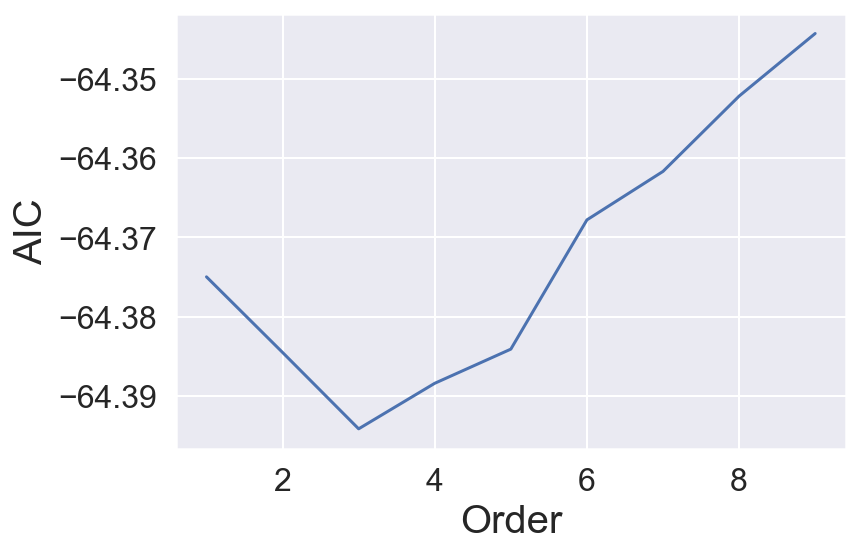

In [56]:
#Let's plot the AIC curve to figure out the order _p_ of the model. The AIC is known to penalize model complexity, and
#its inflexion point represents the optimal order for the model

plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

The lowest AIC score is obtained for order 3, hence we choose VAR(3) a the optimal model.

In [57]:
results = forecasting_model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Jan, 2021
Time:                     16:20:10
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -64.0418
Nobs:                     2555.00    HQIC:                  -64.2663
Log likelihood:           57039.8    FPE:                1.08140e-28
AIC:                     -64.3941    Det(Omega_mle):     1.01841e-28
--------------------------------------------------------------------
Results for equation GBP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000046         0.000211            0.218           0.827
L1.GBP         0.020650         0.028070            0.736           0.462
L1.NOK         0.005895         0.007548            0.781           0.435
L1.SEK        -0

In [58]:
#Compute the VAR(3) log-likelihood: (Very likely the only thing the exercise 3.b really asks for)
results.llf

57039.77936429298

In [59]:
#Compare with VAR(1) log-likelihood:
resultsVAR1 = forecasting_model.fit(2)
resultsVAR1.llf

57000.74184391895

In [60]:
from scipy.stats.distributions import chi2

def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

LR = likelihood_ratio(resultsVAR1.llf,results.llf)

p = chi2.sf(LR, 2) # L2 has 2 DoF more than L1

print('p: %.30f' % p )


p: 0.000000000000000011122958436205


The <b>Likelihood Ratio</b> test statistic is (distributed chi-squared), with one degrees of freedom. The associated p-value, which is _p_ < .001, indicates that the model with all three predictors fits significantly better than the model with only one predictor.

In [61]:
########Not sure the above is a correct interpretation....

Let's analyze the co-integration rank of the differenced time series

In [62]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

cointRank = select_coint_rank(d_curr_diff, det_order=-1, k_ar_diff=1)  #det_order=-1 implies no constant term
print(f'Johansen cointegration rank: {cointRank.rank}')
print(f'Johansen cointegration test results: ')
print(cointRank.summary())


Johansen cointegration rank: 7
Johansen cointegration test results: 
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          7997.          111.8
  1   7          6420.          83.94
  2   7          5218.          60.06
  3   7          4064.          40.17
  4   7          2968.          24.28
  5   7          1917.          12.32
  6   7          923.5          4.130
-------------------------------------


The first differenced series are co-integrated of rank 7. For comparison, we can run the same test on the non-differenced series to see the difference in results

In [63]:
cointRank = select_coint_rank(d_curr, det_order=-1, k_ar_diff=1)  #det_order=-1 implies no constant term

print(f'Johansen cointegration rank: {cointRank.rank}')
print(f'Johansen cointegration test results: ')
print(cointRank.summary())

Johansen cointegration rank: 0
Johansen cointegration test results: 
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          92.15          111.8
-------------------------------------


Unsurprisingly, the non-differenced series are not co-integrated

c) Let's construct log return differenced series

In [64]:
for column in d_curr:
        colname = str(column+'lret')
        d_curr[colname] = np.log(d_curr[column]) - np.log(d_curr[column].shift(1))


lret_curr = d_curr.loc[:,['GBPlret','NOKlret','SEKlret','CHFlret','CADlret','SGDlret','AUDlret']].dropna()
lret_curr.head()

GBPlret   NOKlret   SEKlret   CHFlret   CADlret   SGDlret  \
DATE                                                                     
2002-01-02 -0.001036 -0.015804 -0.031566 -0.022114  0.000563 -0.001539   
2002-01-03 -0.003497  0.000495  0.001655  0.003588 -0.000970 -0.001352   
2002-01-04 -0.000139  0.004006  0.004144  0.002304  0.000501 -0.001056   
2002-01-07 -0.002431 -0.001401 -0.000252  0.000061 -0.000376 -0.002522   
2002-01-08  0.003124  0.002442  0.006489  0.003446  0.000344  0.004064   

             AUDlret  
DATE                  
2002-01-02  0.010744  
2002-01-03 -0.001264  
2002-01-04  0.008524  
2002-01-07  0.000289  
2002-01-08  0.007397

In [65]:
#Let's do a quick sanity check with the ADF test:

adf_lret = []
for column in lret_curr:
    adf_test = adfuller(lret_curr[column], regression='ct')
    adf_lret.append(
        {
            'currency': column,
            'adf': adf_test[0],
            'p-value':  adf_test[1]
        }
    )

adf_lret_df = pd.DataFrame(adf_lret)
adf_lret_df

currency        adf       p-value
0  GBPlret -10.607594  1.294116e-16
1  NOKlret -10.409505  3.246675e-16
2  SEKlret -10.605301  1.307817e-16
3  CHFlret -10.741168  7.040509e-17
4  CADlret -18.410894  0.000000e+00
5  SGDlret -11.819717  7.600572e-19
6  AUDlret -17.472024  0.000000e+00

Text(0.5, 0, 'Order')

Text(0, 0.5, 'AIC')

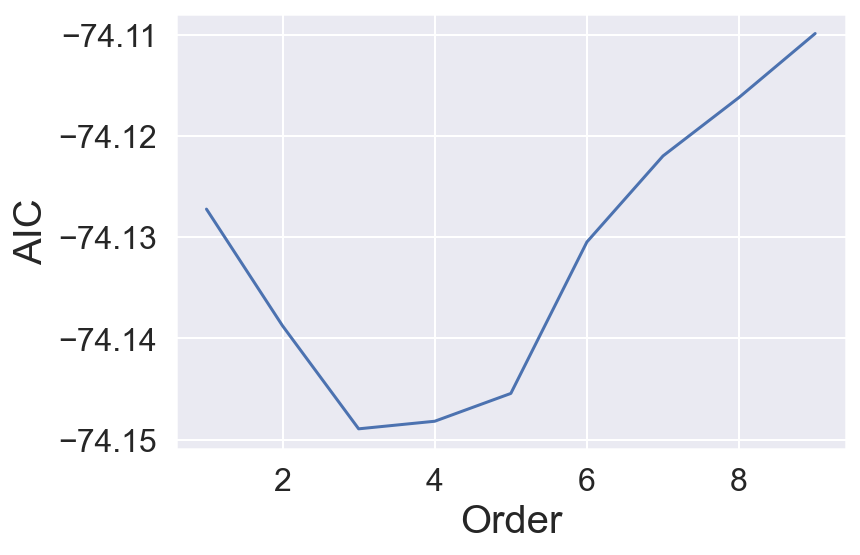

In [66]:
#The series appear to be stationary, so we can fit a VAR model

##First, we check the optimal order:
forecasting_model = VAR(lret_curr)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

###Question for Raja: it seems that the optimal order is VAR(3), but the exercise calls for VAR(5), why?

In [67]:
#Per exercise, let's fit a VAR(5) model
results = VAR(lret_curr).fit(5)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Jan, 2021
Time:                     16:20:13
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -73.5685
Nobs:                     2553.00    HQIC:                  -73.9362
Log likelihood:           69540.8    FPE:                6.29578e-33
AIC:                     -74.1454    Det(Omega_mle):     5.70796e-33
--------------------------------------------------------------------
Results for equation GBPlret
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000028         0.000126            0.221           0.825
L1.GBPlret         0.037214         0.028219            1.319           0.187
L1.NOKlret         0.037841         0.029530            1.281         

In [68]:
#let's extract the residuals:
curr_resid = results.resid
curr_resid.head()

GBPlret   NOKlret   SEKlret   CHFlret   CADlret   SGDlret  \
DATE                                                                     
2002-01-09 -0.003032  0.001888  0.000599  0.004314  0.000077  0.000958   
2002-01-10  0.002796 -0.001925 -0.007896 -0.000119  0.003233 -0.003771   
2002-01-11 -0.000870  0.000531 -0.000976  0.000449 -0.002179  0.000615   
2002-01-14  0.005435 -0.005215  0.003933 -0.003867  0.000257 -0.003290   
2002-01-15 -0.003222  0.002041  0.000413  0.004311 -0.003624 -0.005872   

             AUDlret  
DATE                  
2002-01-09  0.001673  
2002-01-10  0.000136  
2002-01-11 -0.003974  
2002-01-14 -0.003705  
2002-01-15  0.000201

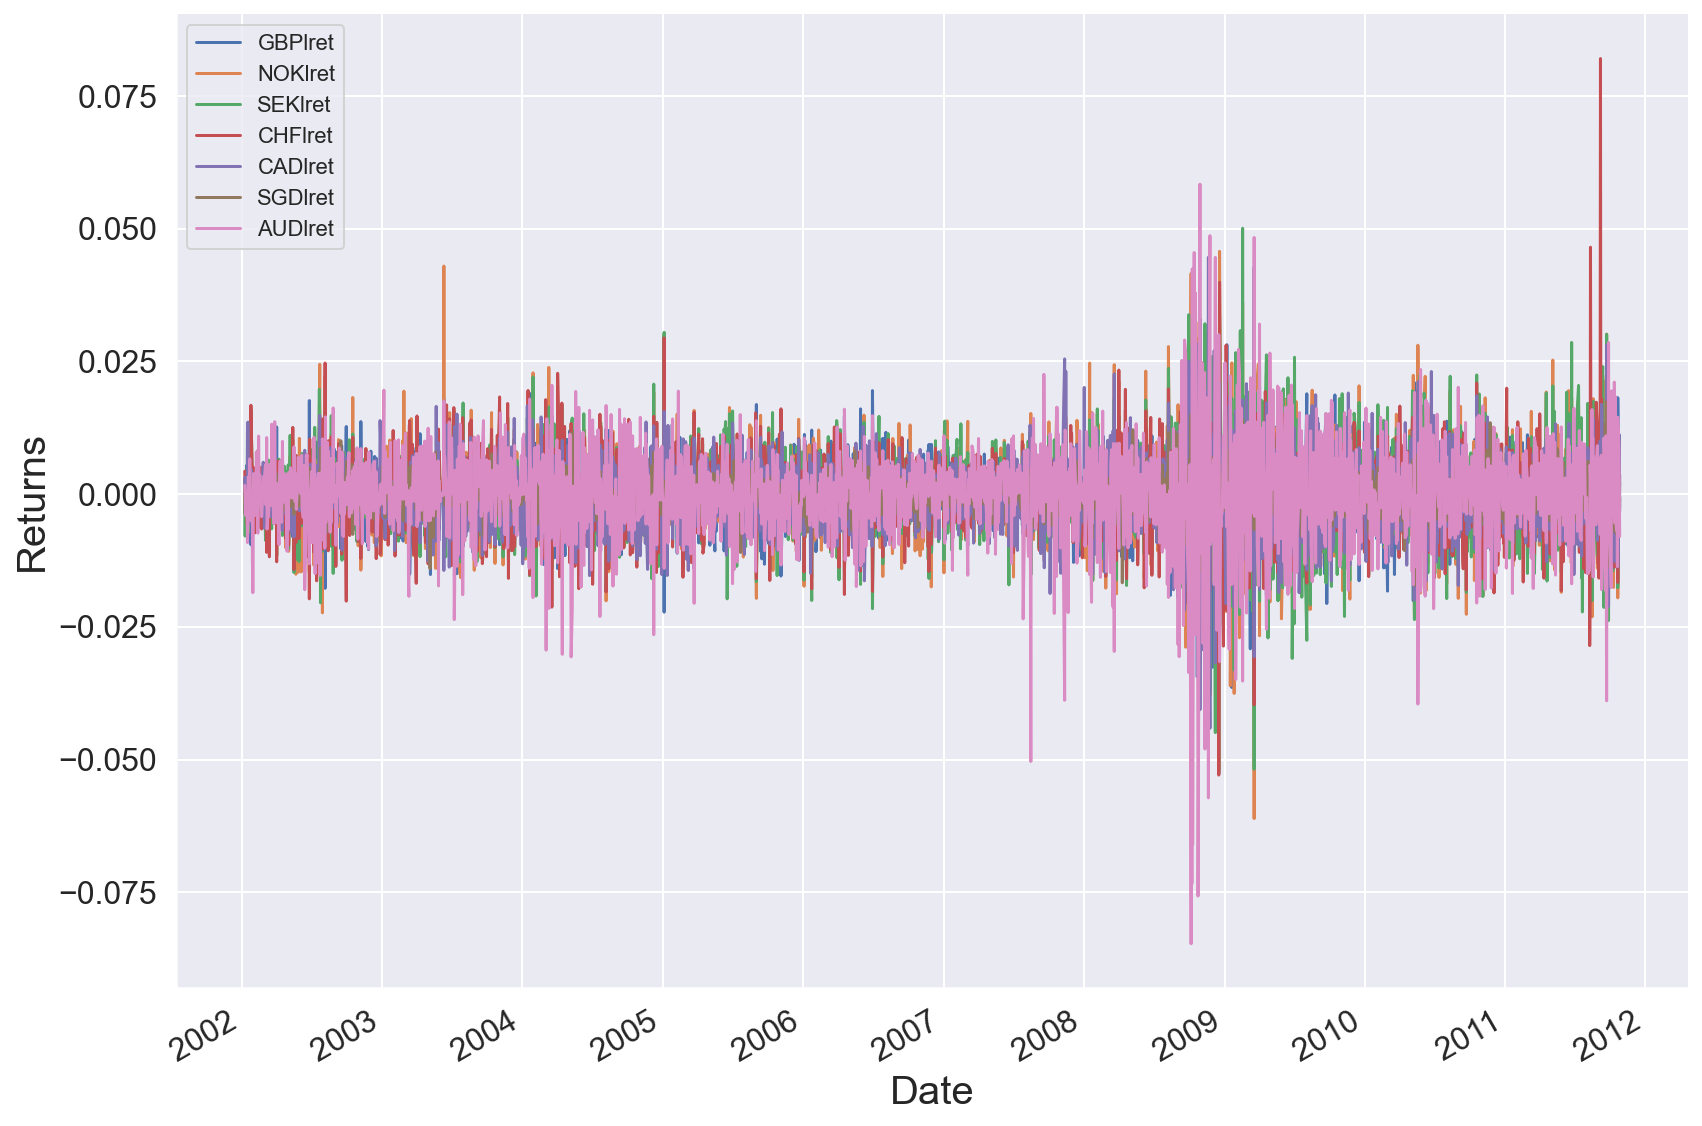

In [69]:
#inspecting time series of residuals
fig,ax = plt.subplots(figsize=(12,8))
_ = curr_resid.GBPlret.plot(ax = ax)
_ = curr_resid.NOKlret.plot(ax = ax)
_ = curr_resid.SEKlret.plot(ax = ax)
_ = curr_resid.CHFlret.plot(ax = ax)
_ = curr_resid.CADlret.plot(ax = ax)
_ = curr_resid.SGDlret.plot(ax = ax)
_ = curr_resid.AUDlret.plot(ax = ax)
_ = plt.xlabel('Date')
_ = plt.ylabel('Returns')
_ = plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

With a high-level visual inspection, the individual time series of residuals appear like they could be white noise (at least in the 2002-2006 date range), but the data clearly indicates the presence of regimes.

In [70]:
#Let's test this assumption like we did in Exercise 1
stats_df = curr_resid[dt.datetime(2002, 1, 1, 0, 0) : dt.datetime(2006, 12, 31, 0, 0)].apply(calc_distributional_properties)
stats_df2 = stats_df.T
stats_df2['JB_test'] = stats_df2.apply(lambda x: JB(x), axis=1)
stats_df2

skew  kurtosis  studentized range   count     JB_test
GBPlret -0.071417  0.913205           8.046458  1297.0   46.170203
NOKlret  0.383170  2.116575          10.071284  1297.0  273.837981
SEKlret  0.133370  0.886405           8.319153  1297.0   46.306303
CHFlret  0.021577  0.875199           8.056153  1297.0   41.495145
CADlret  0.007067  0.516503           6.489850  1297.0   14.427769
SGDlret -0.024389  2.107129          10.379760  1297.0  240.073078
AUDlret -0.474990  1.828979           7.978817  1297.0  229.548882

The Jarque-Bera test at 95% rejects the normality of the individual time series of residuals, even on the more consistent regime of 2002-2006.

Let's now proceed to a multivariate analysis of the residuals:

(d) Using the residuals from (c), compute the ${\Gamma}$<sub>k</sub> matrix in (3.48) for k = 5; 10; 20 and obtain the _M_-matrix in (3.49).

In [71]:
###No luck solving this part i'm afraid ...
results.resid_acov(5)

array([[[ 3.91317624e-05, -3.21877120e-05, -3.28125125e-05,
         -2.37951718e-05, -2.00870815e-05, -6.34075903e-06,
          3.29779888e-05],
        [-3.21877120e-05,  6.62755863e-05,  5.49429047e-05,
          3.65528585e-05,  2.95040956e-05,  9.96260761e-06,
         -4.62248015e-05],
        [-3.28125125e-05,  5.49429047e-05,  6.54568726e-05,
          3.72577080e-05,  3.01791194e-05,  9.95612529e-06,
         -4.71757011e-05],
        [-2.37951718e-05,  3.65528585e-05,  3.72577080e-05,
          5.01388431e-05,  1.62593975e-05,  6.20668713e-06,
         -2.61311950e-05],
        [-2.00870815e-05,  2.95040956e-05,  3.01791194e-05,
          1.62593975e-05,  4.32773536e-05,  5.99971691e-06,
         -3.83915310e-05],
        [-6.34075903e-06,  9.96260761e-06,  9.95612529e-06,
          6.20668713e-06,  5.99971691e-06,  9.15772019e-06,
         -1.25795708e-05],
        [ 3.29779888e-05, -4.62248015e-05, -4.71757011e-05,
         -2.61311950e-05, -3.83915310e-05, -1.25795708e-05

(e) Plot _MY<sub>t</sub>_ and comment on the linear combination that has low volatility.

(f) Check (a)–(e) for various regimes; note 2008–2009 is noted for its volatility.